In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# grab csv data
electric_gen = pd.read_csv('../electricity_generation_extractor/us_electric_generation_2001_20.csv')
us_emissions = pd.read_csv('us_emissions_2000_2018.csv')

### Use Code Below for testing the chart builder by one state at a time

In [7]:
# set emissions columns by sector
emissions_columns = ['State', 'Year', 'emission_sub_electric', 'emission_by_industrial', 'emission_by_agriculture', 'emission_by_waste',
                     'emission_by_forestry', 'emission_by_bunker_fuel', 'emission_sub_commercial', 'emission_sub_residential',
                     'emission_sub_industrial', 'emission_sub_transportation', 'emission_sub_fugitive']

# building test data
ny_emissions = us_emissions.loc[(us_emissions['Year']>=2001) & (us_emissions['State']=='New York'), emissions_columns]
il_emissions = us_emissions.loc[(us_emissions['Year']>=2001) & (us_emissions['State']=='Illinois'), emissions_columns]
tx_emissions = us_emissions.loc[(us_emissions['Year']>=2001) & (us_emissions['State']=='Texas'), emissions_columns]

In [8]:
# define function to perform the grouping calculations on a dataframe
# returns the cleaned grouped df
def group_df_by_emissions(emissions_data):
    dirty_power = ['emission_sub_electric']
    buildings = ['emission_sub_residential', 'emission_sub_commercial']
    transportation = ['emission_sub_transportation']
    dumps_farms_industrial = ['emission_by_waste', 'emission_sub_industrial', 'emission_by_agriculture']
    fuels = ['emission_sub_fugitive', 'emission_by_bunker_fuel']

    columns_list = [['dirty_power', dirty_power], 
                    ['buildings', buildings],
                    ['transportation', transportation], 
                    ['dumps_farms_industrial', dumps_farms_industrial], 
                    ['fuels', fuels]]

    # build each bucketed totals
    for calc in columns_list: 
        emissions_data[calc[0]] = emissions_data.loc[:, calc[1]].sum(axis=1)
    
    # just rewrite a buckets list to concat through, sheer laziness here
    buckets = ['dirty_power', 'buildings', 'transportation', 'dumps_farms_industrial'] # emitted fuels from the totals for now
    # build the bucket % makeup for that year
    for bucket in buckets:
        emissions_data['%_'+bucket] = round(emissions_data[bucket] / emissions_data[buckets].sum(axis=1), 2) * 100

    return emissions_data

### build test data sets
# only use if you'd like to do one at a time
ny_emissions_chart_data = group_df_by_emissions(ny_emissions)
il_emissions_chart_data = group_df_by_emissions(il_emissions)
tx_emissions_chart_data = group_df_by_emissions(tx_emissions)


In [45]:
def show_area_plot_over_years_emissions(emissions_data, cols_to_keep):
    
    emissions_data.index = emissions_data['Year']
    bottom = np.zeros(len(emissions_data))

    fig , ax = plt.subplots()

    for i, col in enumerate(emissions_data[cols_to_keep]):
        ax.bar(
            emissions_data.index, 
            emissions_data[col],
            bottom=bottom)
        bottom += np.array(emissions_data[col])

    
    list_iterator = 0
    total_list = [bar.get_height() for bar in ax.patches]
    
    for bar in ax.patches:
        
        # set the y_offset variable to be -1% of whatever the height is
        y_offset = bar.get_height() - (bar.get_height() * 0.1)
            
        
        ax.text(
            # Put the text in the middle of each bar. get_x returns the start
            # so we add half the width to get to the middle.
            bar.get_x() + bar.get_width() / 2,
            # Vertically, add the height of the bar to the start of the bar,
            # along with the offset.
            bar.get_height() + bar.get_y() + y_offset,
            # This is actual value we'll show.
            str(round(
                int(bar.get_height() / sum(total_list[list_iterator:len(total_list):18]) * 100))) + "%",
            # Center the labels and style them a bit.
            ha='center',
            color='w',
            weight='bold',
            size=10
        )
        
        # reset list iterator to next value or 0 again. Convuluated way to access the values
        # in ax.patches in the right order
        list_iterator = list_iterator + 1
        
        if list_iterator == 4:
            list_iterator = 0
        else: 
            pass

    plt.xlabel('Year')
    plt.xticks(emissions_data.index, rotation=0)

    plt.ylabel('Emissions (mtC02e)')
    

    legend_label = ['dirty power', 'buildings', 'transportation', 'dumps, farms, industrial']
    plt.legend(legend_label, ncol = 4, bbox_to_anchor=([1, 1.05, 0, 0]), frameon = False)
    plt.title('{} emissions from 2001 - 2018\n'.format(emissions_data['State'].unique()[0]),loc='left')

    fig.set_size_inches(11.5, 8.5)
    plt.savefig('emissions_charts/{}_emissions_2001-18.png'.format(emissions_data['State'].unique()[0]))

In [46]:
# uncomment to show emissions plots
# this is assuming you've filtered down to one state per chart
cols_breakdown_100 = ['%_dirty_power', '%_buildings', '%_transportation', '%_dumps_farms_industrial']
cols_total = ['dirty_power', 'buildings', 'transportation', 'dumps_farms_industrial']
#show_area_plot_over_years_emissions(tx_emissions_chart_data, cols_total)


In [47]:
### let's do a similar thing with generation data
# subset our 3 states for now
target_cols = ['state', 'year', 'coal', 'natural_gas', 'petro_liquids', 'nuclear', 'hydro_electric', 'all_solar', 'wind']

ny_electric_gen = electric_gen.loc[electric_gen['state']=='NY', target_cols]
il_electric_gen = electric_gen.loc[electric_gen['state']=='IL', target_cols]
tx_electric_gen = electric_gen.loc[electric_gen['state']=='TX', target_cols]

In [48]:
# define function to perform the grouping calculations on a dataframe
# returns the cleaned grouped df
def group_df_by_generation(generation_data):
    columns_list = ['coal', 'natural_gas', 'petro_liquids', 'nuclear', 'hydro_electric', 'all_solar', 'wind']

    # build each bucketed totals
    for calc in columns_list: 
        generation_data[calc+'_%'] = round(generation_data[calc] / generation_data[columns_list].sum(axis=1), 2) * 100

    return generation_data

ny_generation_chart_data = group_df_by_generation(ny_electric_gen)
il_generation_chart_data = group_df_by_generation(il_electric_gen)
tx_generation_chart_data = group_df_by_generation(tx_electric_gen)


In [49]:
def show_area_plot_over_years_generation(generation_data, cols_to_keep):
    
    generation_data.index = generation_data['year']
    bottom = np.zeros(len(generation_data))

    fig , ax = plt.subplots()

    for i, col in enumerate(generation_data[cols_to_keep]):
        ax.bar(
            generation_data.index, 
            generation_data[col],
            bottom=bottom)
        bottom += np.array(generation_data[col])

    
    y_offset = -10000
    list_iterator = 0
    total_list = [bar.get_height() for bar in ax.patches]
    for bar in ax.patches:
        ax.text(
            # Put the text in the middle of each bar. get_x returns the start
            # so we add half the width to get to the middle.
            bar.get_x() + bar.get_width() / 2,
            # Vertically, add the height of the bar to the start of the bar,
            # along with the offset.
            bar.get_height() + bar.get_y() + y_offset,
            # This is actual value we'll show.
            str(round(
                int(bar.get_height() / sum(total_list[list_iterator:len(total_list):19]) * 100))) + "%" \
                if int(bar.get_height() / sum(total_list[list_iterator:len(total_list):19]) * 100) >= 10 else "" ,
            # Center the labels and style them a bit.
            ha='center',
            color='w',
            weight='bold',
            size=10
        )
        
    # reset list iterator to next value or 0 again. Convuluated way to access the values
        # in ax.patches in the right order
        list_iterator = list_iterator + 1
        
        if list_iterator == len(cols_to_keep):
            list_iterator = 0
        else: 
            pass

    plt.xlabel('Year')
    plt.xticks(generation_data.index, rotation=0)

    plt.ylabel('Electricity Generation (tMW hours)')
    

    legend_label = ['coal', 'natural gas', 'petro liquids', 'nuclear', 'hydro electric', 'solar', 'wind']
    plt.legend(legend_label, ncol = 7, bbox_to_anchor=([1, 1.05, 0, 0]), frameon = False)
    plt.title('{} Elec generation from 2001 - 2020\n'.format(generation_data['state'].unique()[0]),loc='left')

    fig.set_size_inches(11.5, 8.5)
    plt.savefig('generation_charts/{}_elec_gen_2001-20.png'.format(generation_data['state'].unique()[0]))
    plt.show()

In [50]:
# cols_to_keep = ['coal_%', 'natural_gas_%', 'petro_liquids_%', 'nuclear_%', 'hydro_electric_%', 'all_solar_%', 'wind_%']
cols_totals = ['coal', 'natural_gas', 'petro_liquids', 'nuclear', 'hydro_electric', 'all_solar', 'wind']
#show_area_plot_over_years_generation(il_generation_chart_data, cols_totals)

### Run Code Below when you want to generate all of the charts for all 50 states at once

South Carolina is done!
Hawaii is done!
North Dakota is done!
South Dakota is done!
Arizona is done!
New Mexico is done!
Delaware is done!
California is done!
Iowa is done!
Colorado is done!
Texas is done!
Georgia is done!
Florida is done!
New Jersey is done!
Alaska is done!
Wisconsin is done!
North Carolina is done!
New Hampshire is done!
Alabama is done!
Vermont is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Missouri is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Pennsylvania is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Connecticut is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Wyoming is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Kentucky is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


United States is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Nevada is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


New York is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Mississippi is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Nebraska is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Utah is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Ohio is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Idaho is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Maine is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Indiana is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Michigan is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Louisiana is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Rhode Island is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


District Of Columbia is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Illinois is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Maryland is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Tennessee is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Washington is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


West Virginia is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Virginia is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Massachusetts is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Oklahoma is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Oregon is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Minnesota is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Montana is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Arkansas is done!


<ipython-input-45-f7f4dfebed73>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig , ax = plt.subplots()


Kansas is done!


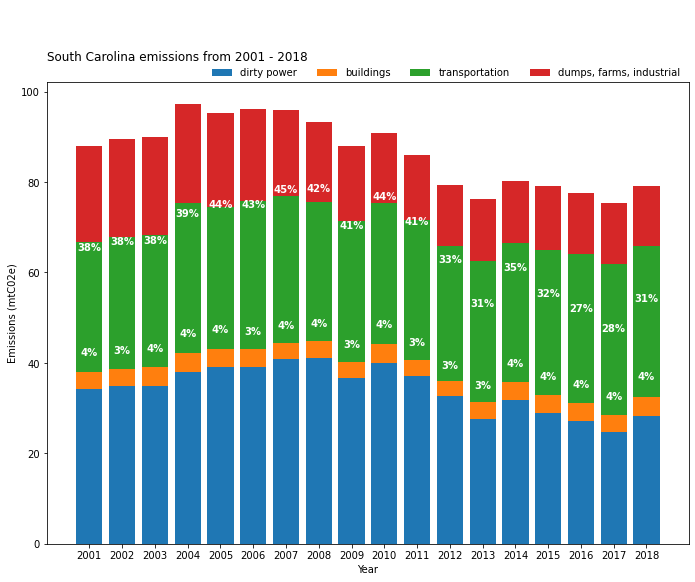

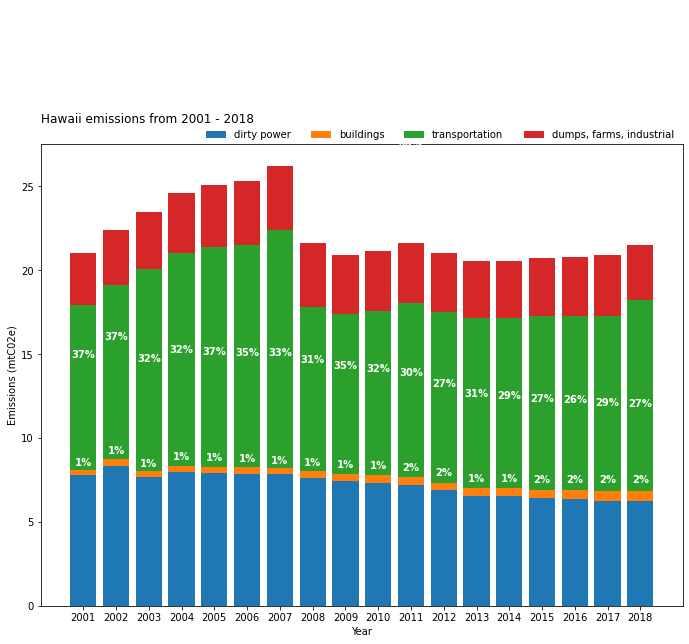

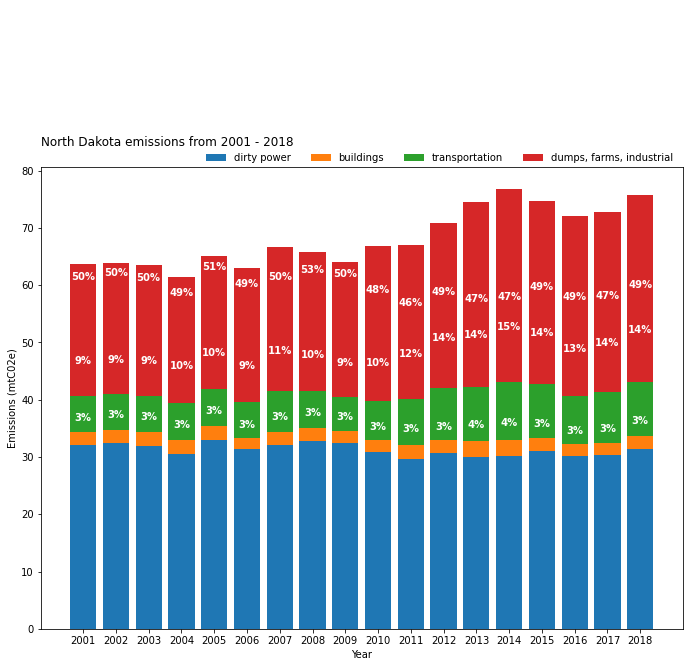

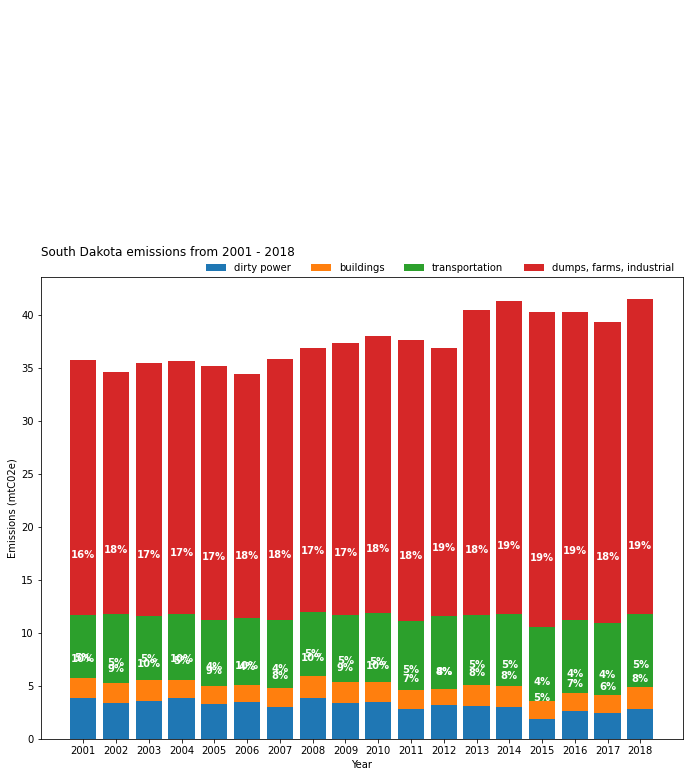

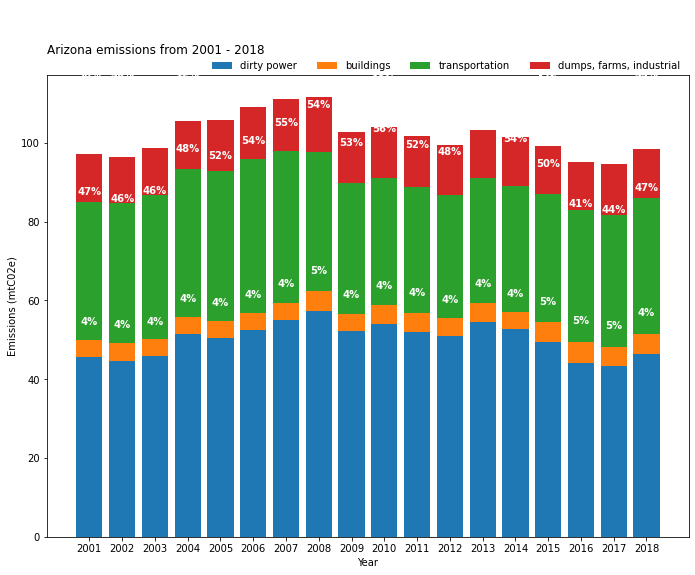

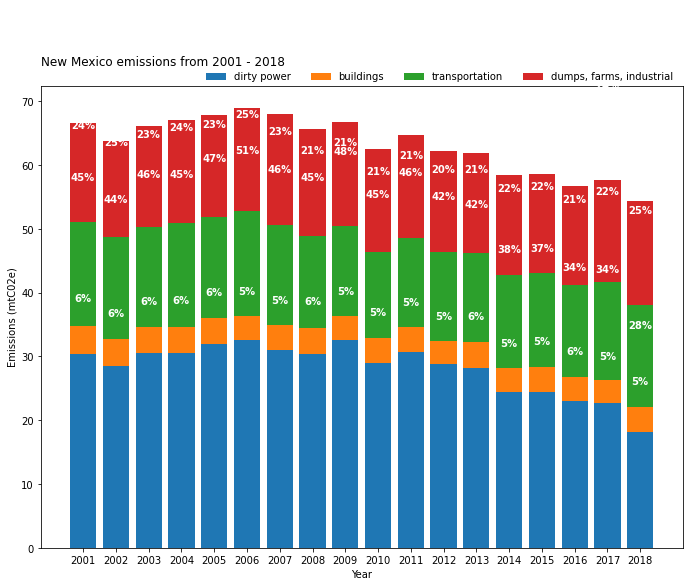

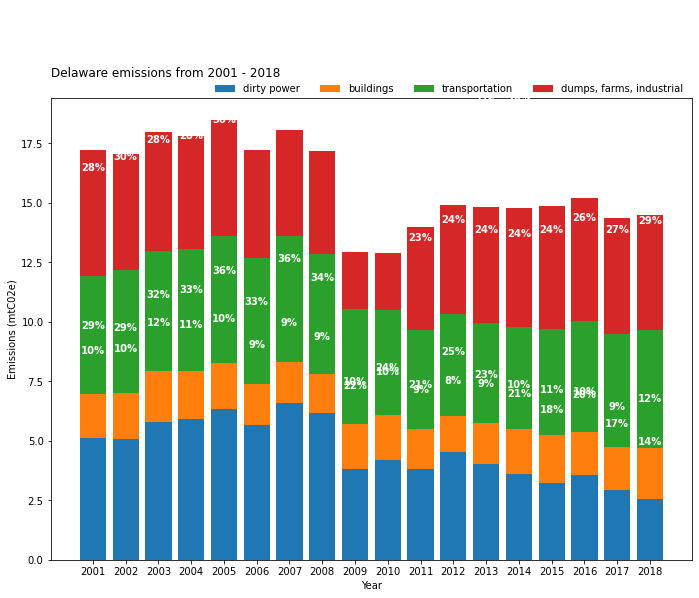

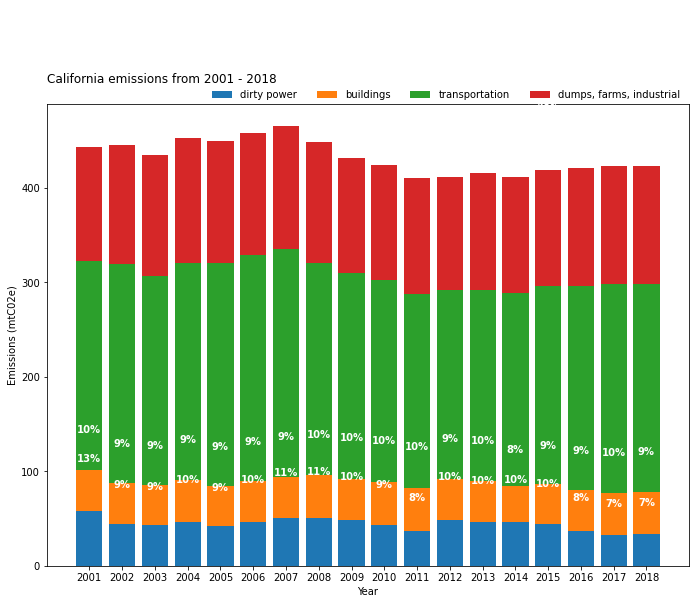

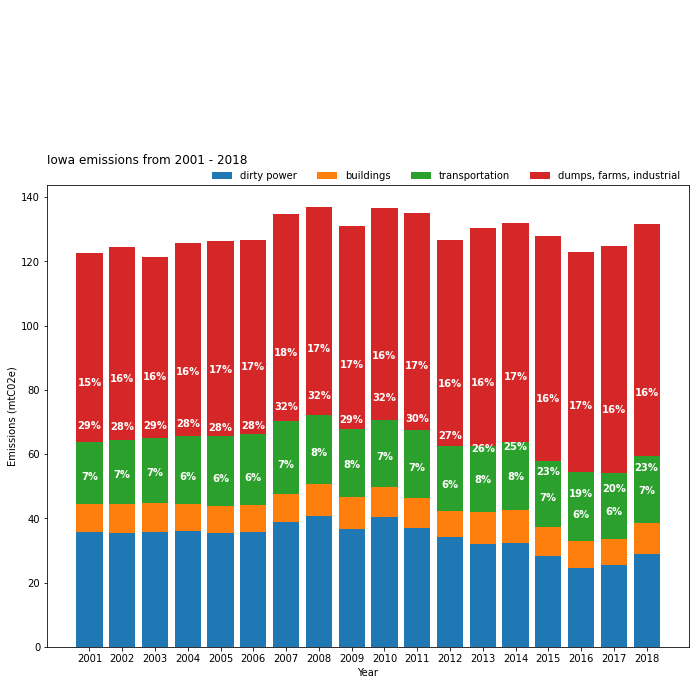

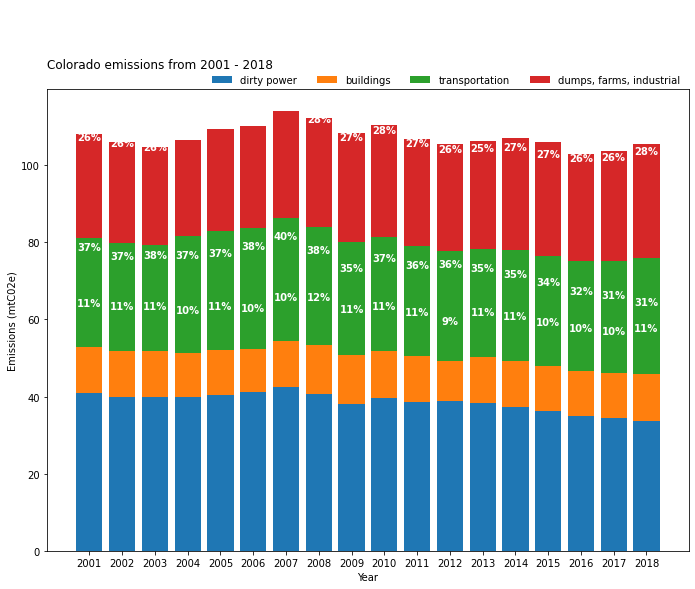

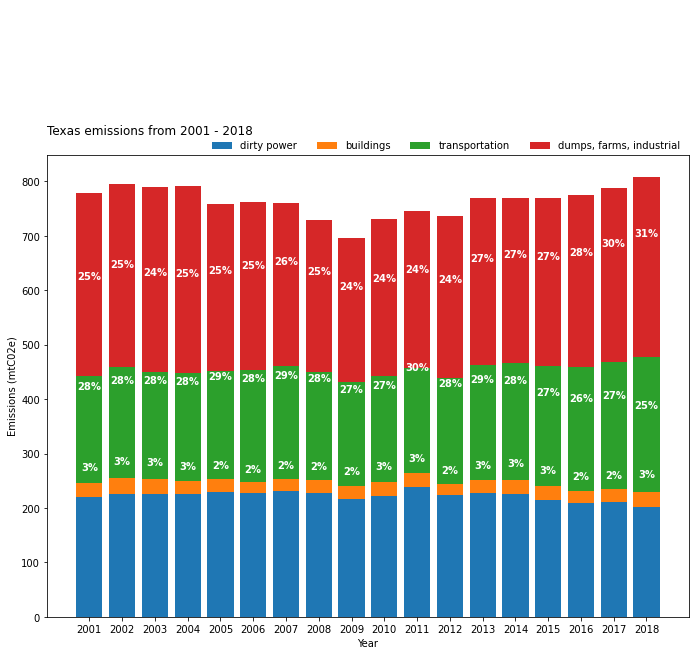

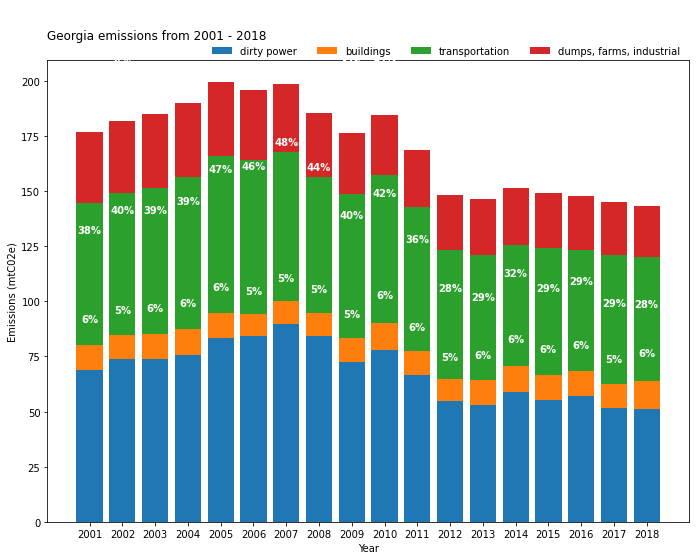

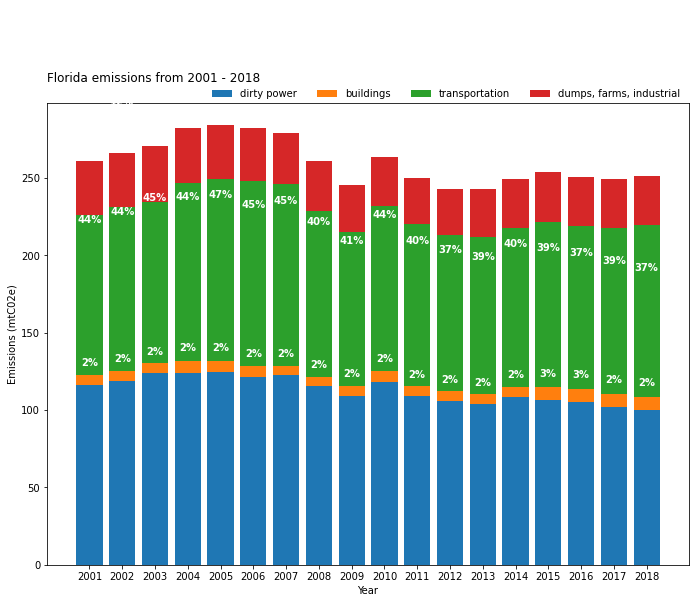

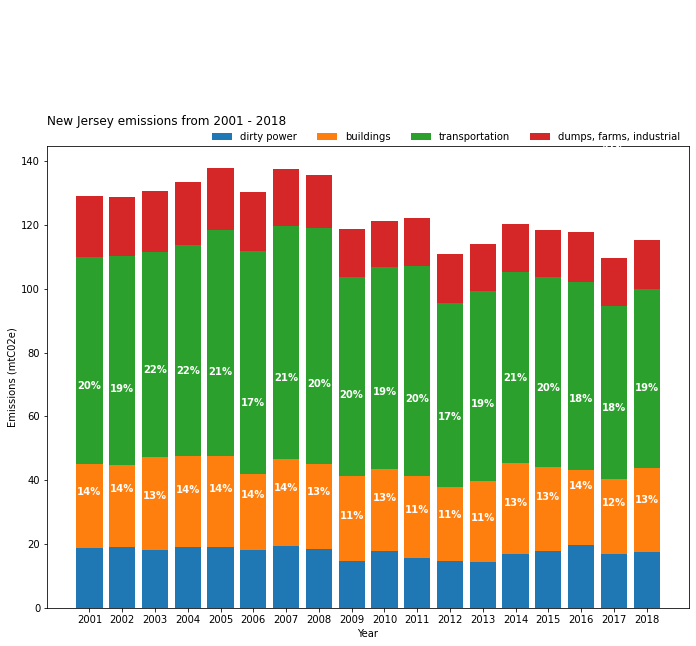

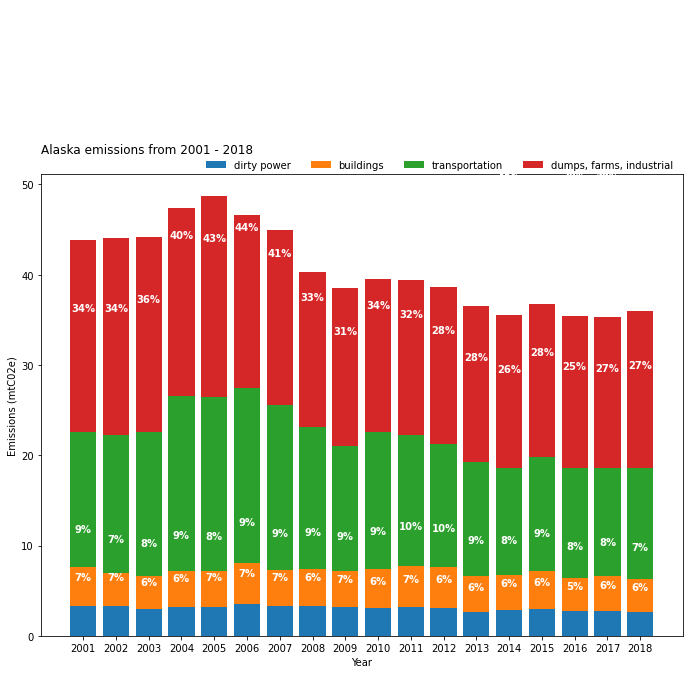

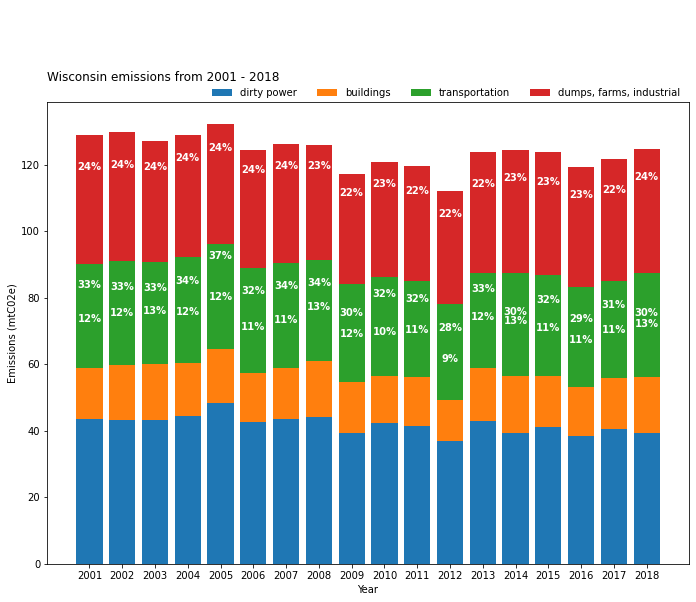

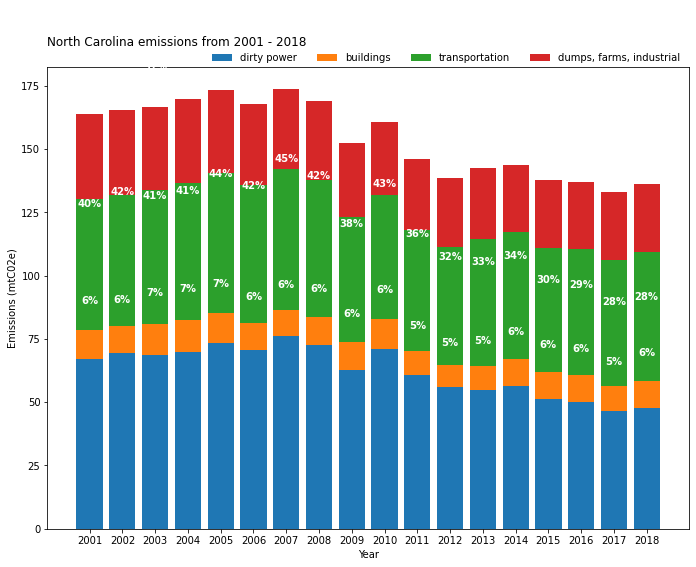

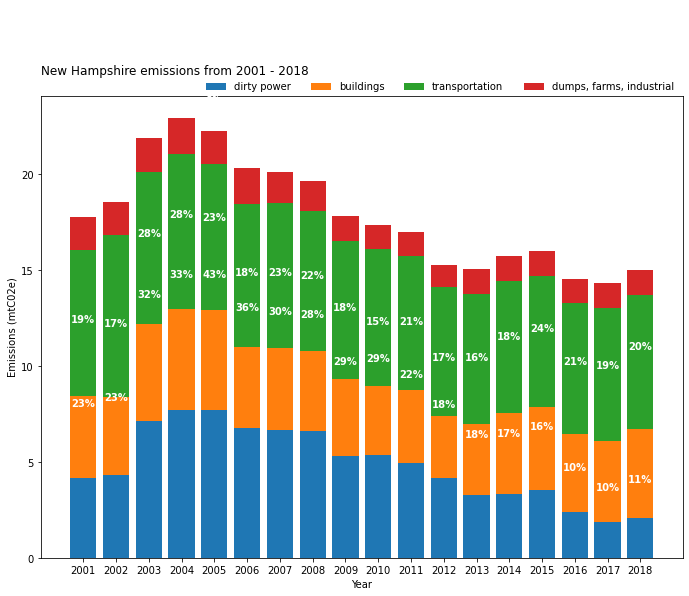

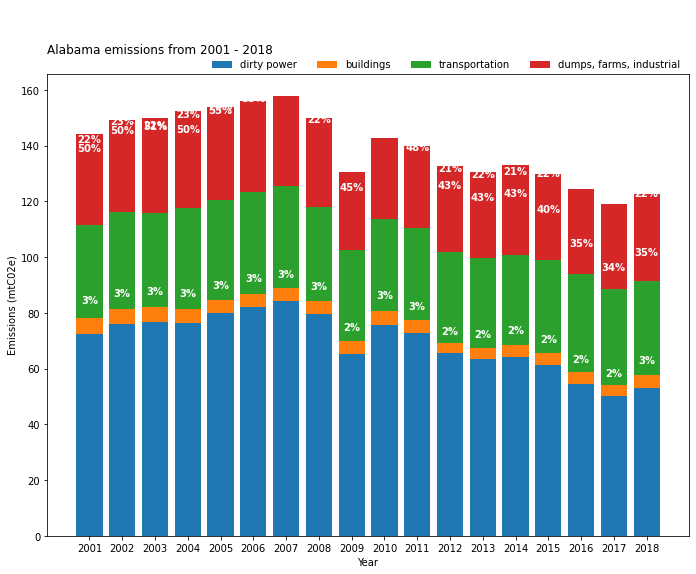

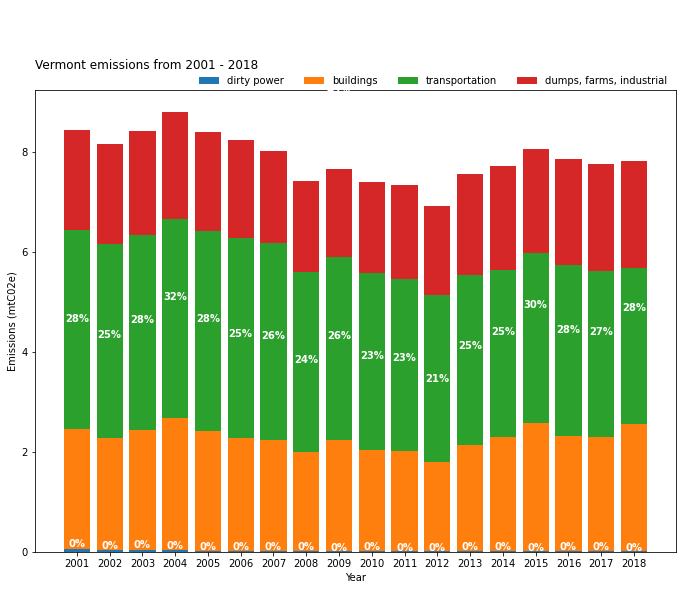

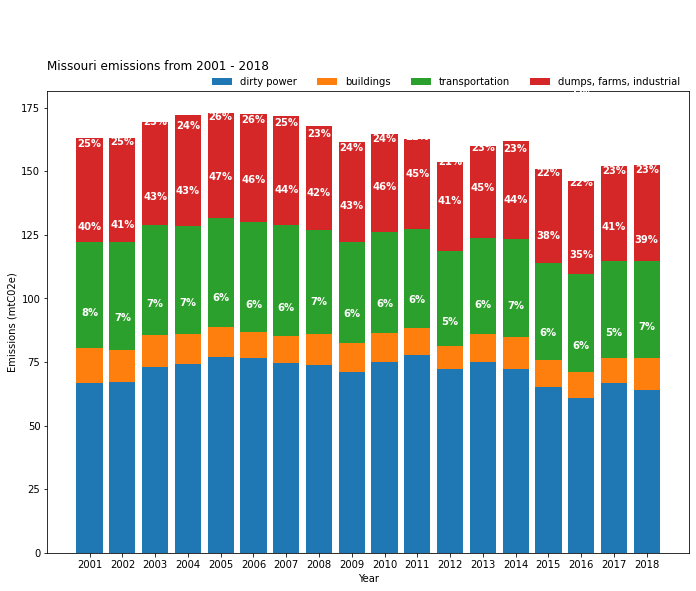

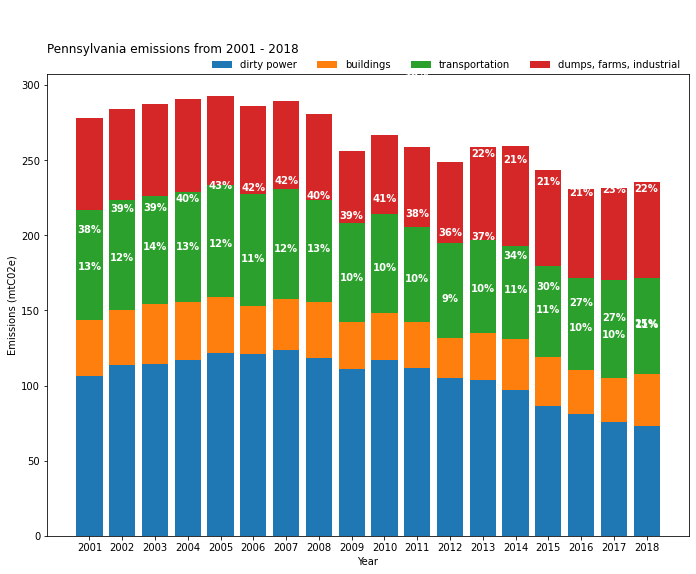

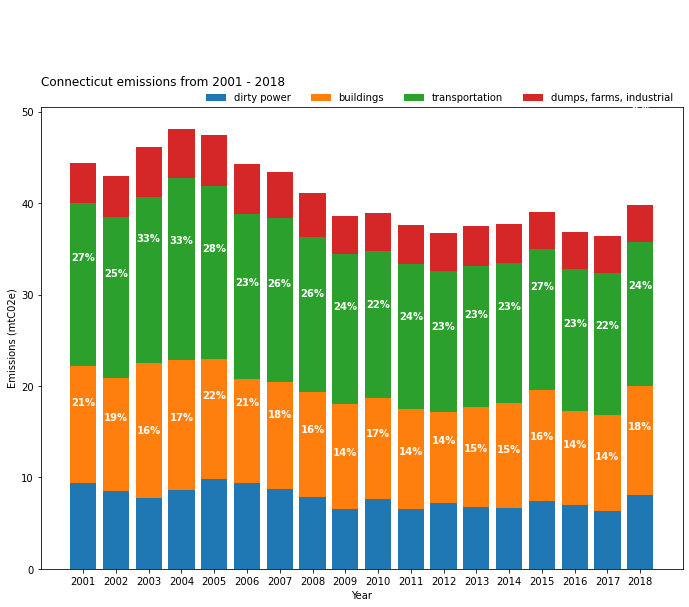

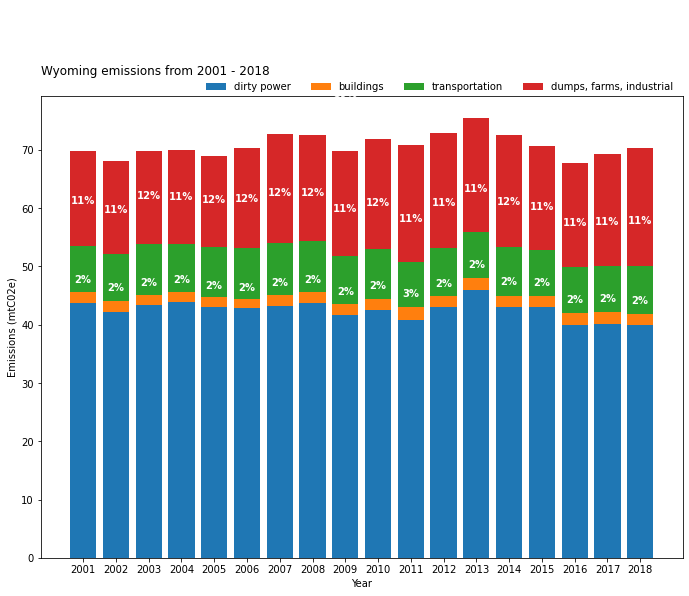

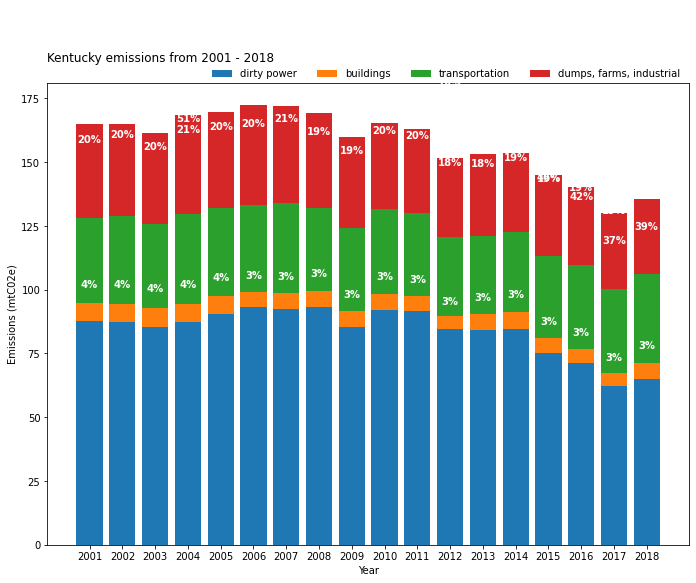

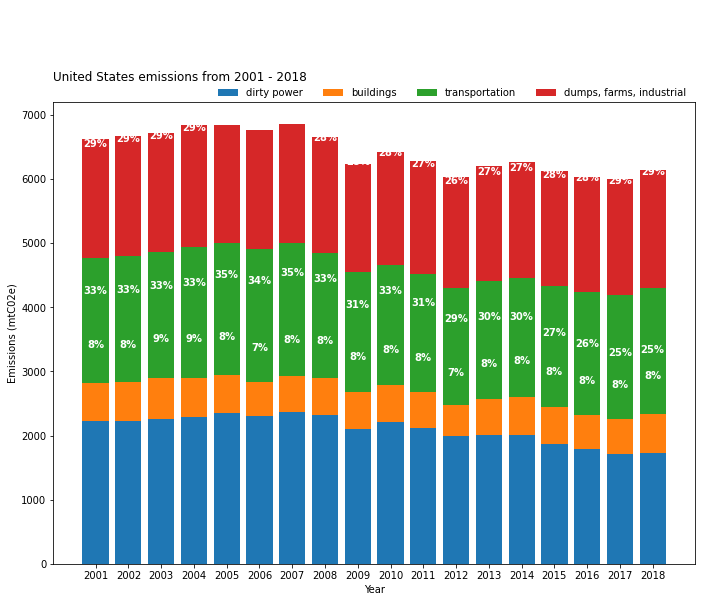

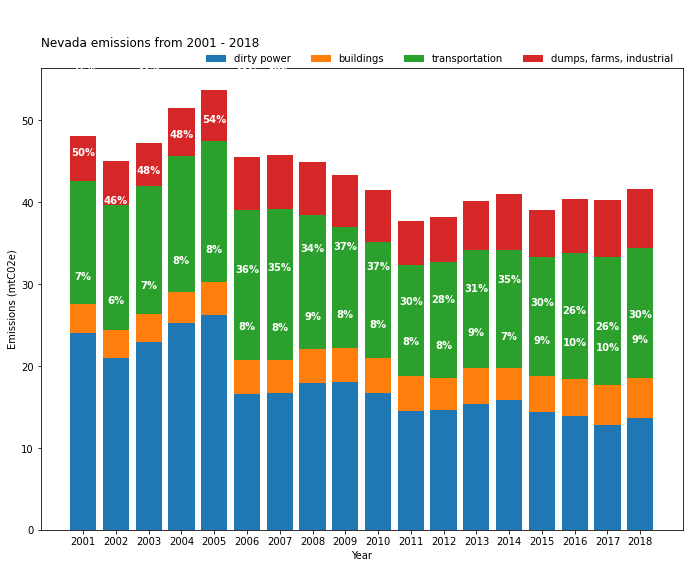

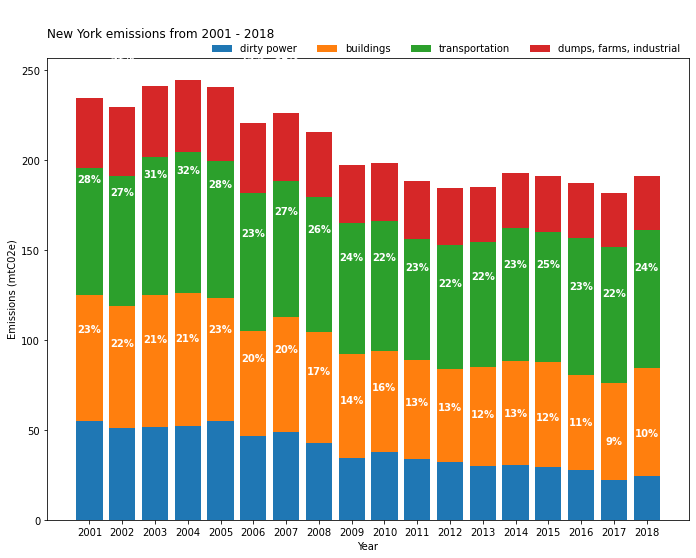

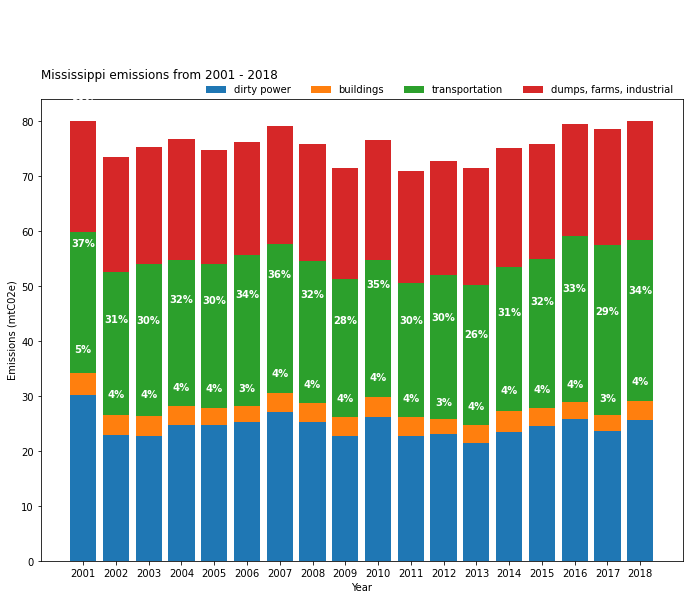

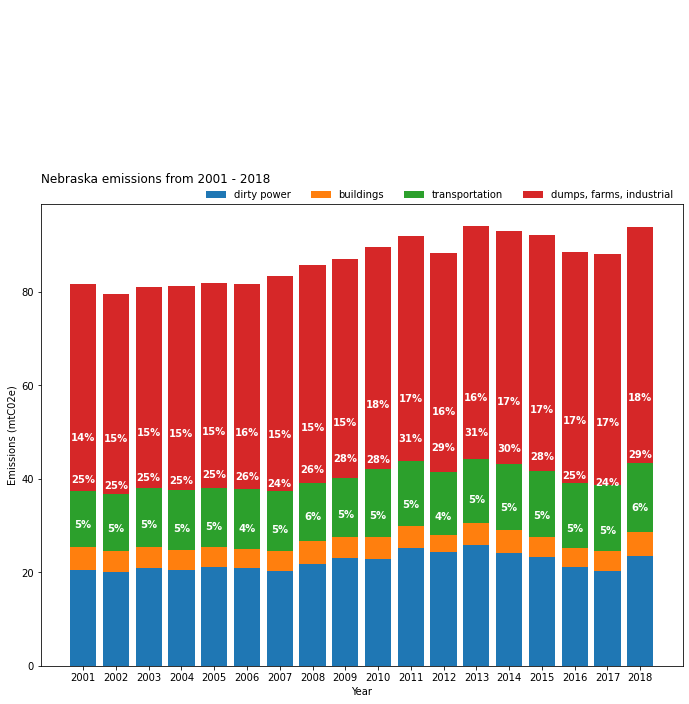

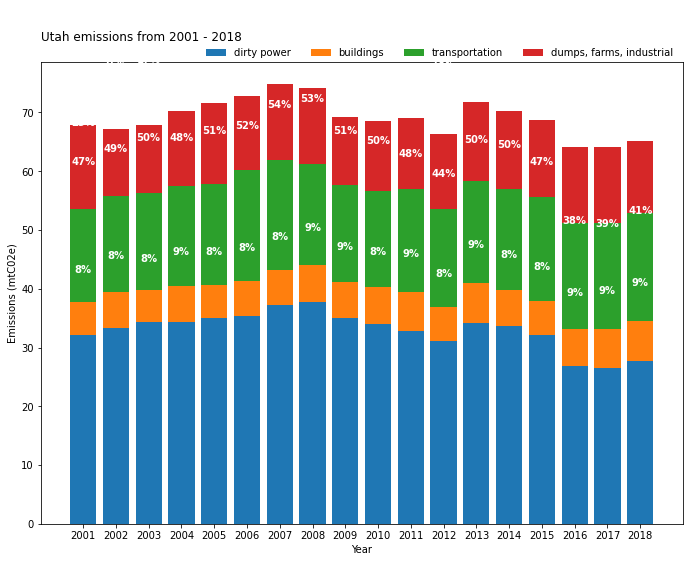

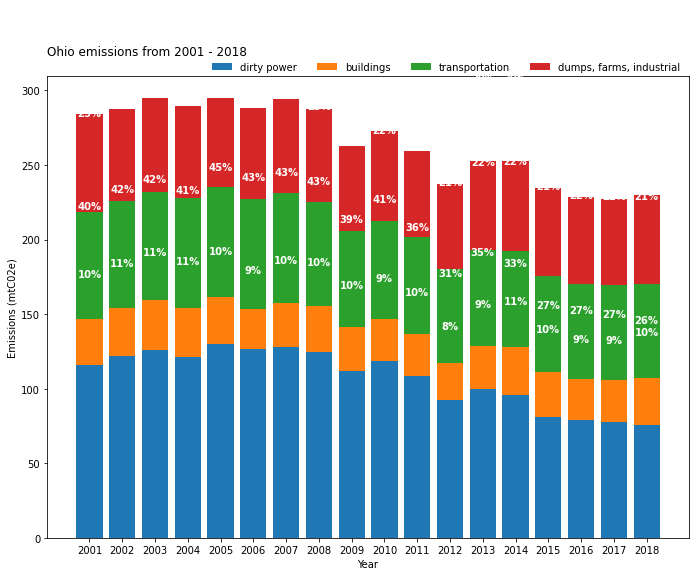

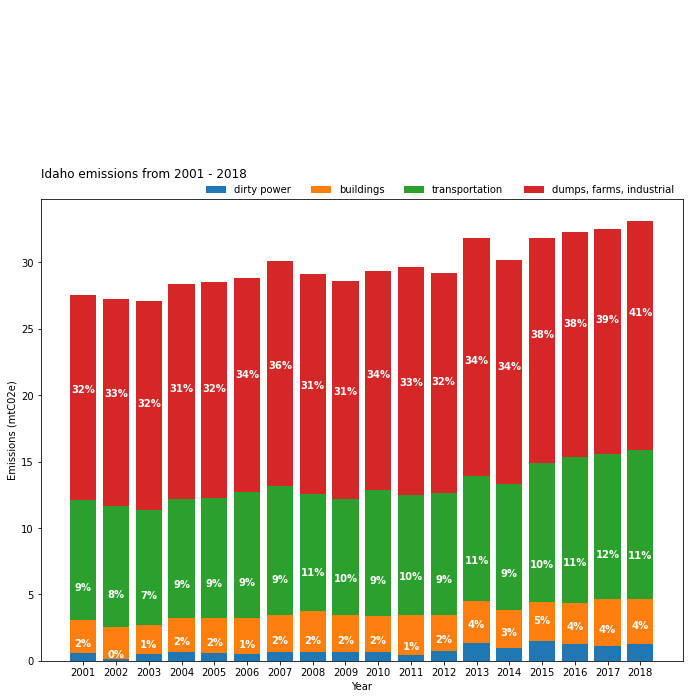

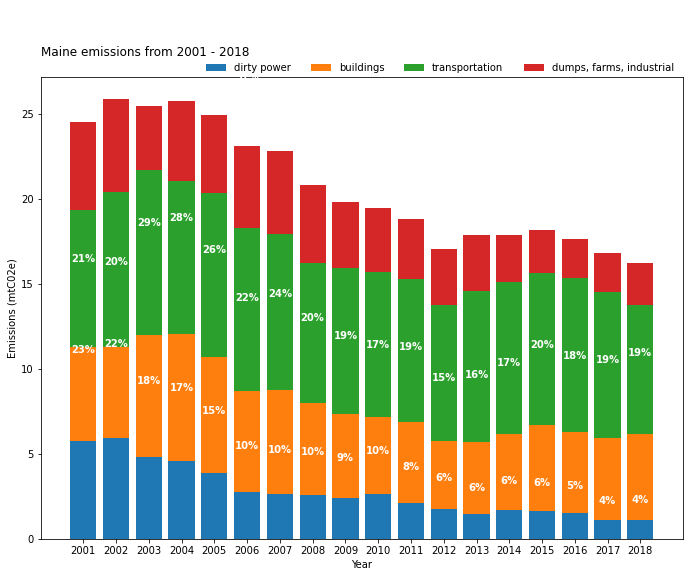

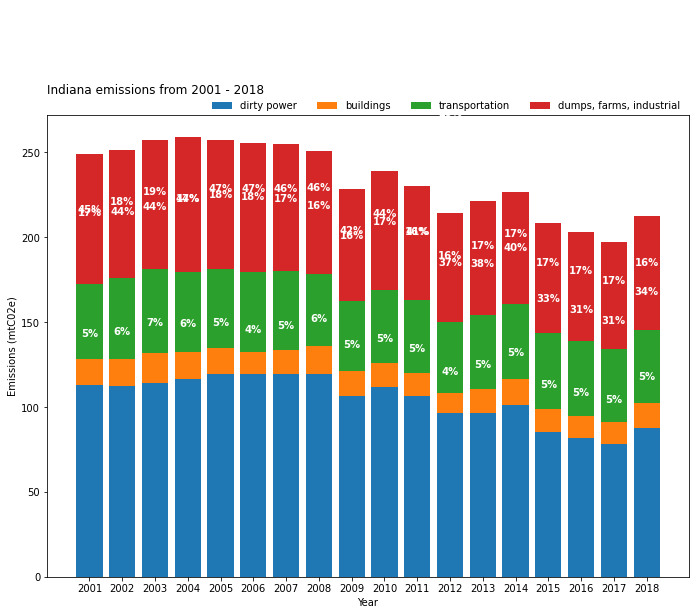

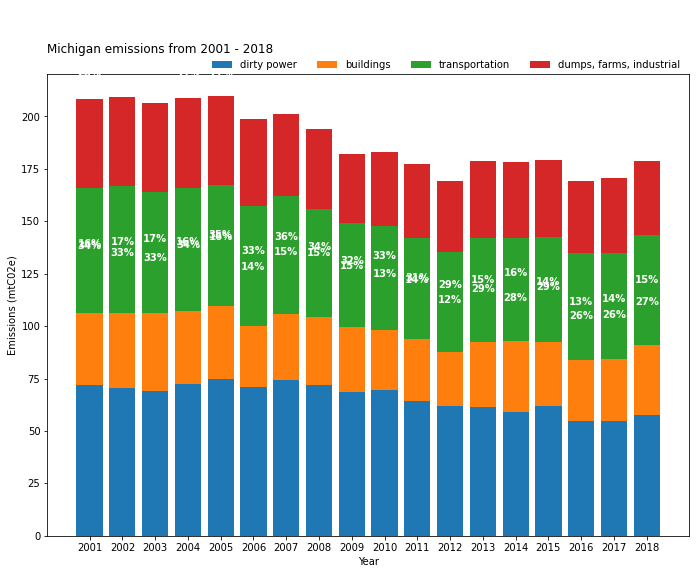

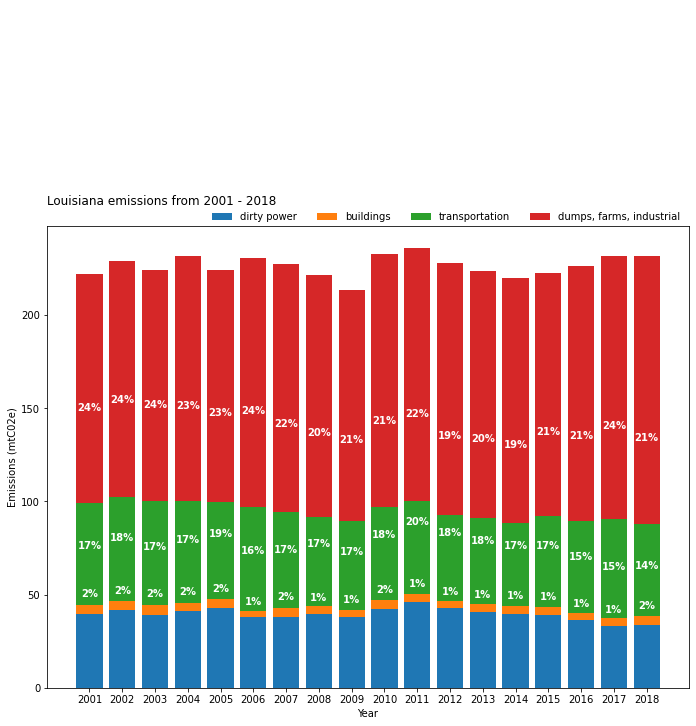

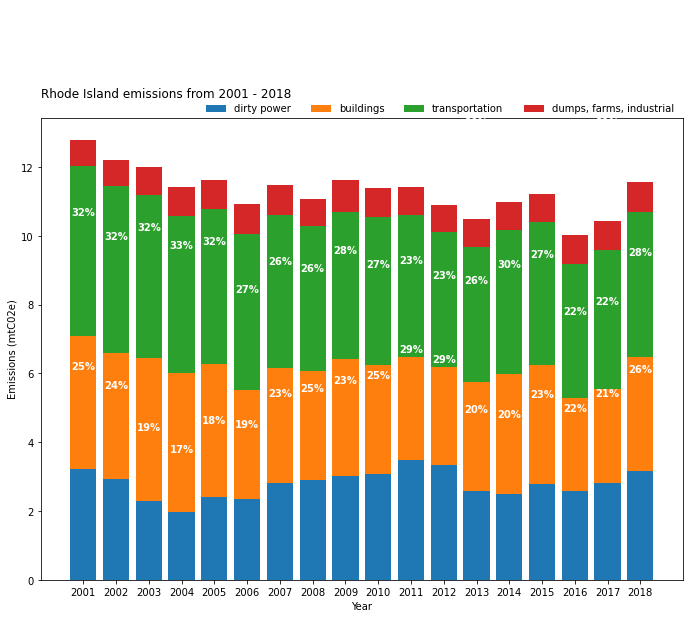

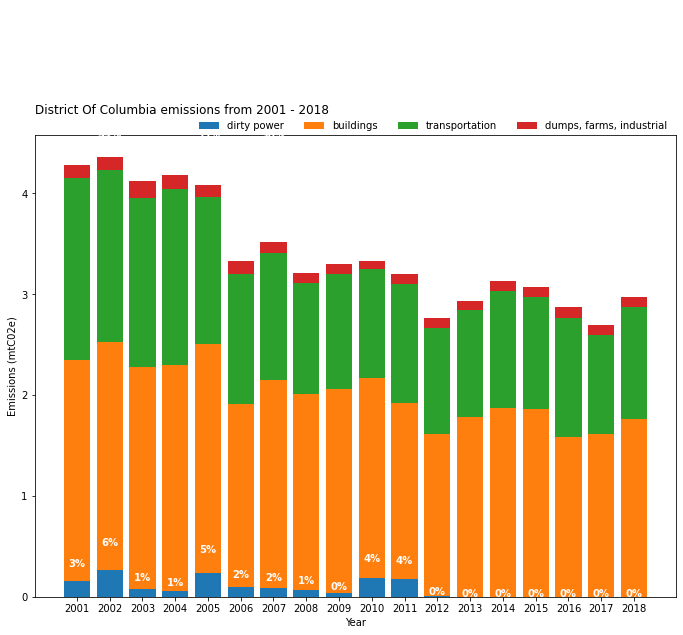

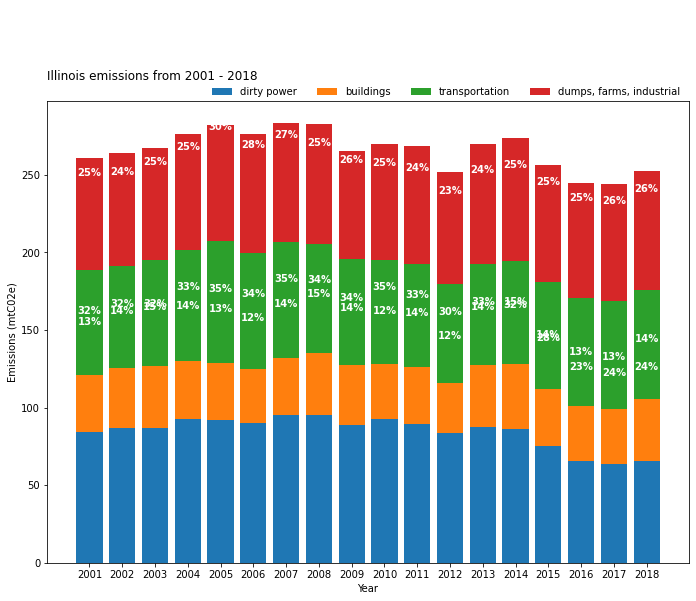

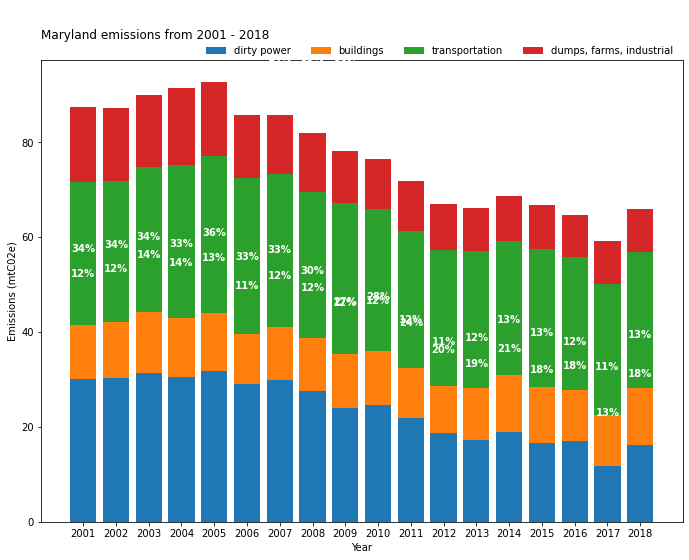

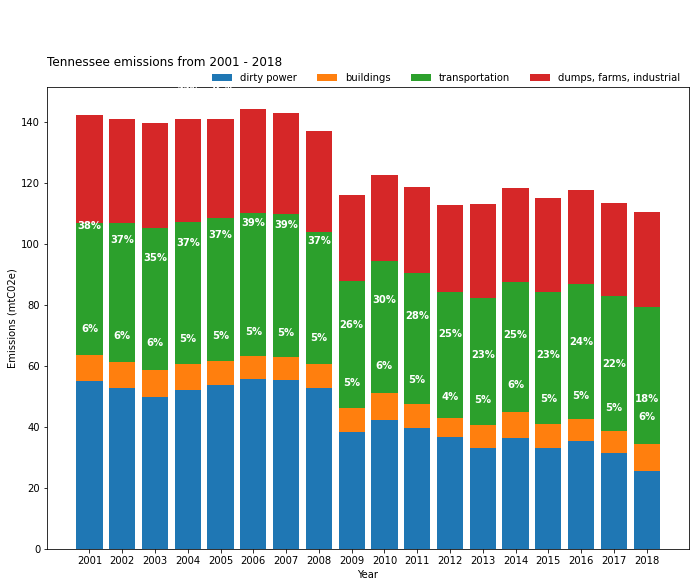

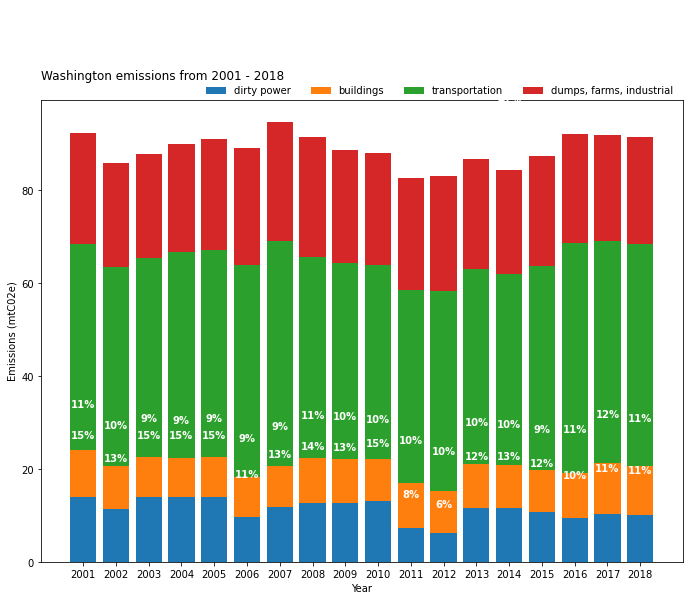

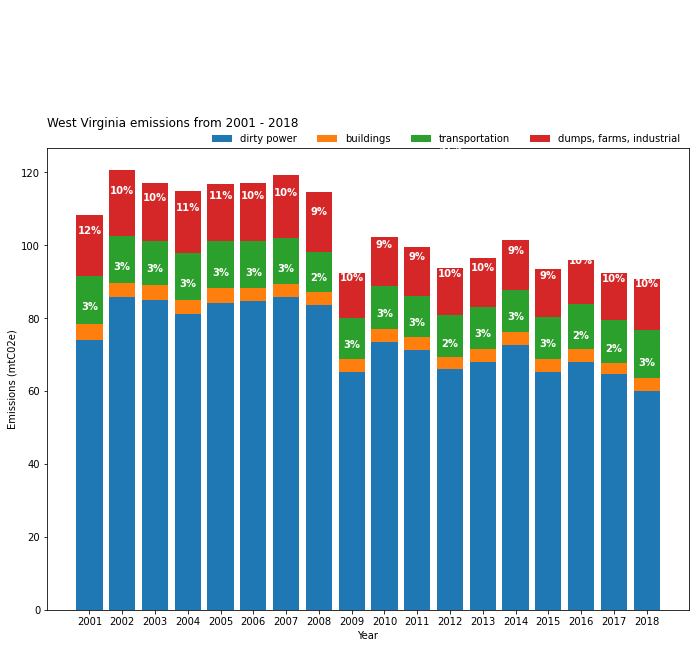

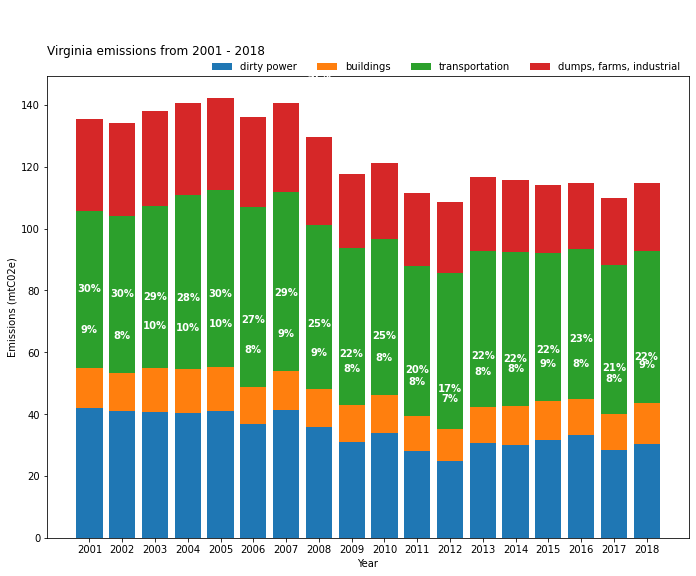

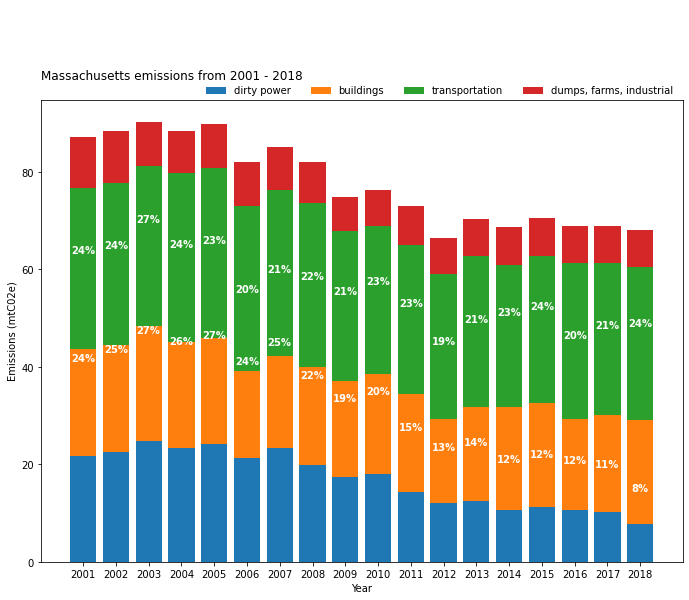

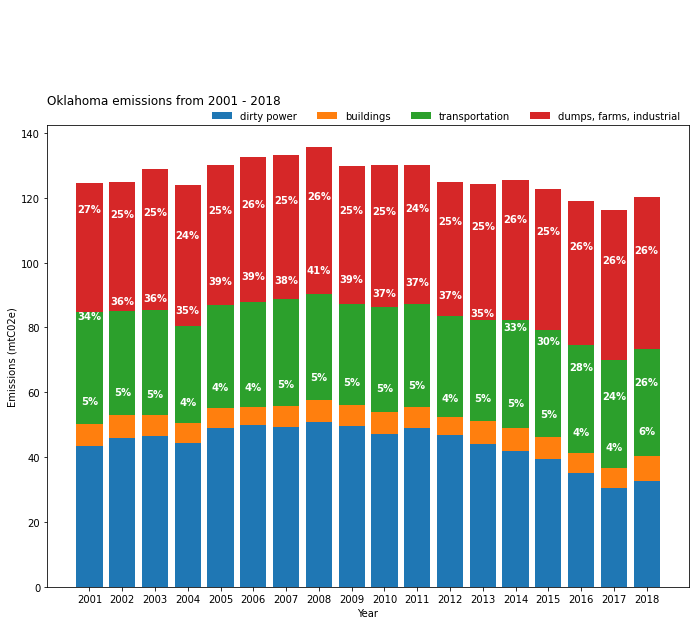

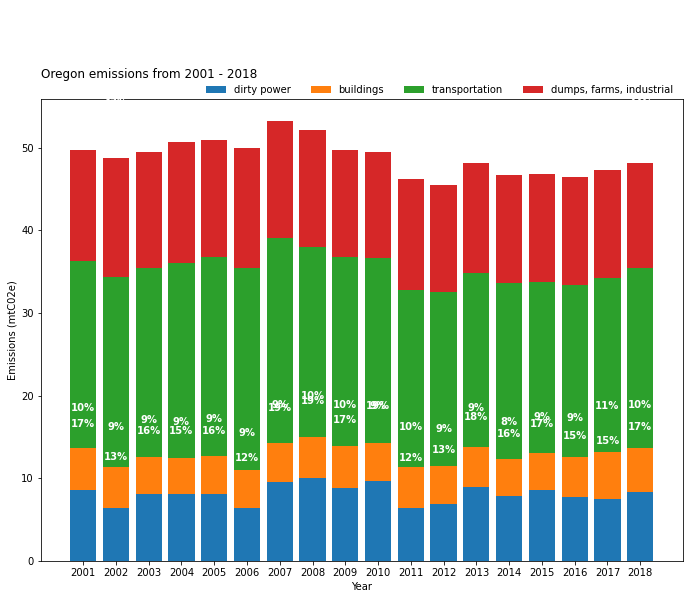

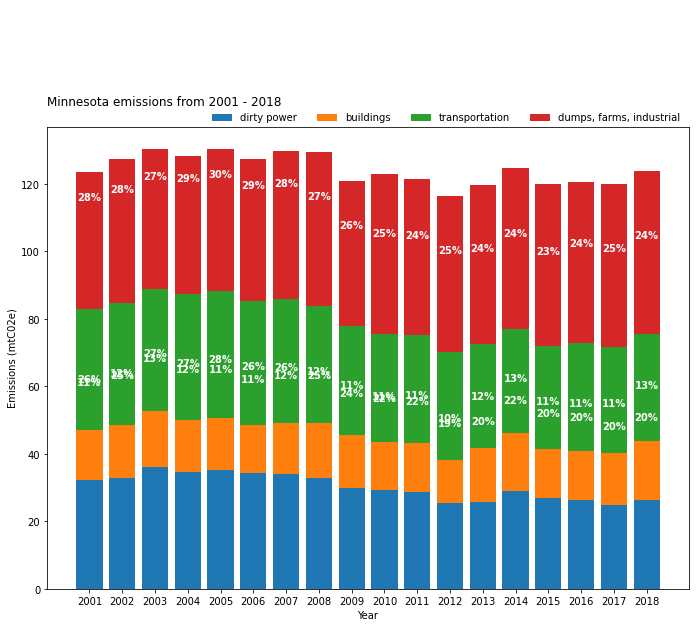

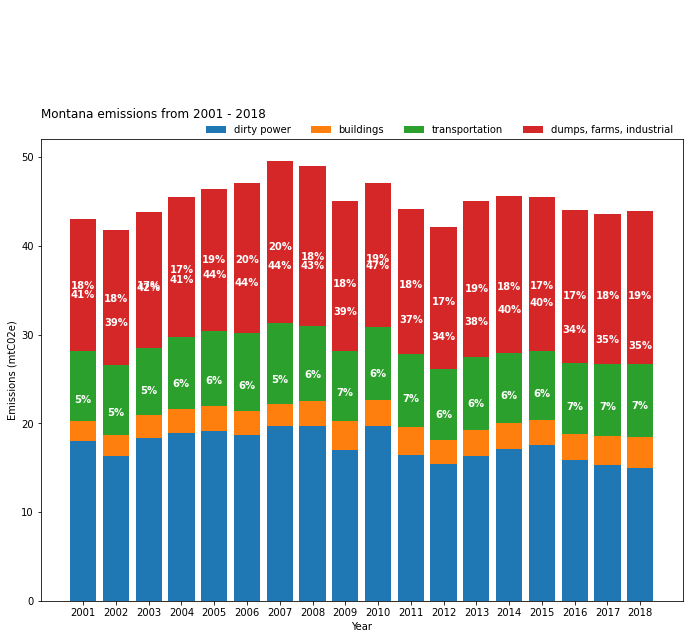

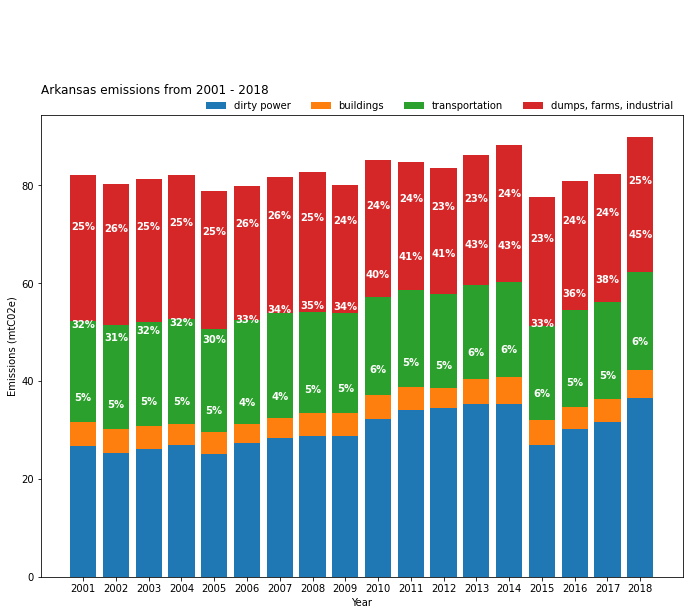

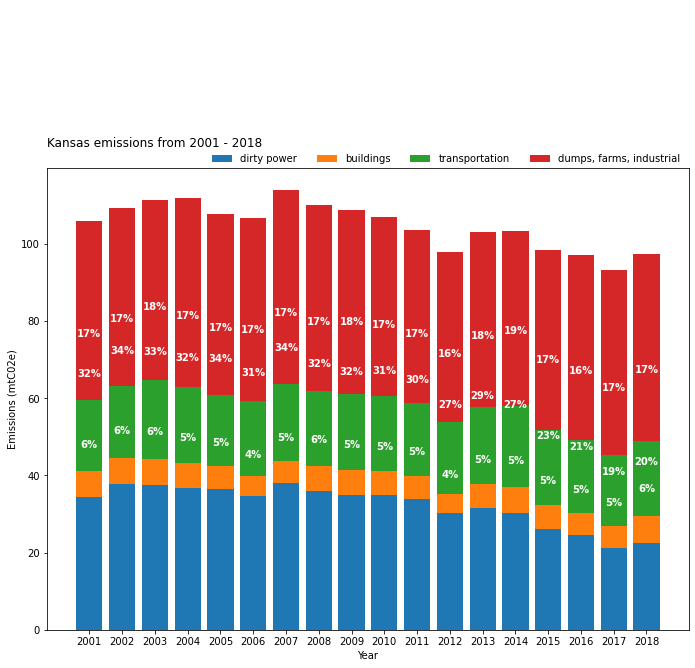

In [51]:
# First, let's grab all of the unique values in the us_emissions data and set it to a list
emissions_states = list(set(us_emissions['State']))

# prep the us_emissions data so it has the groupings that we need
emissions_prepped = group_df_by_emissions(us_emissions)
cols_total = ['dirty_power', 'buildings', 'transportation', 'dumps_farms_industrial']

# loop through all of the states and save them individually in their folder
for state in emissions_states:
    show_area_plot_over_years_emissions(
            emissions_prepped.loc[(emissions_prepped['State']==state) & (emissions_prepped['Year']>=2001)], 
            cols_total)
    
    print('{} is done!'.format(state))

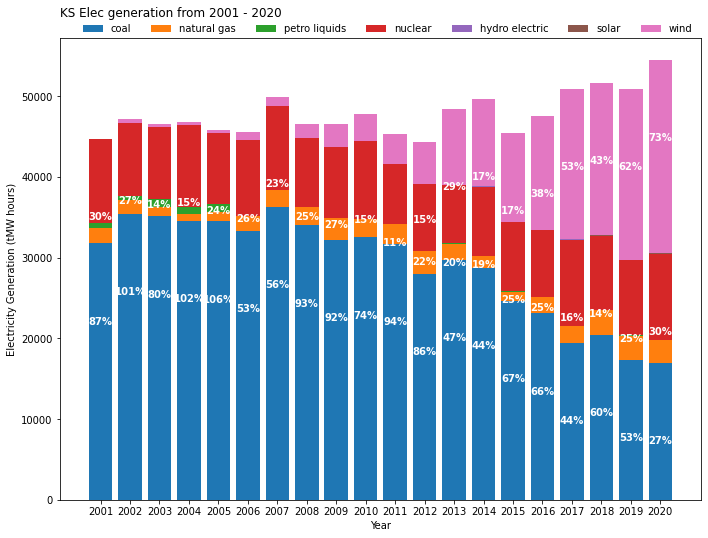

KS is done!


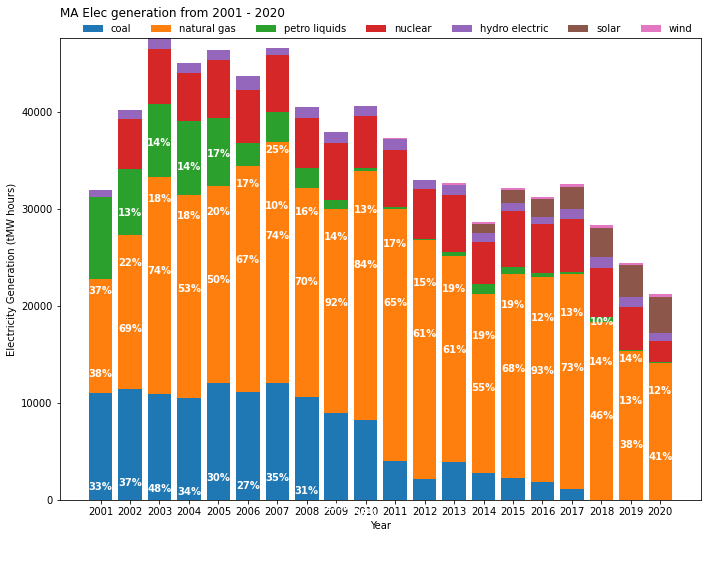

MA is done!


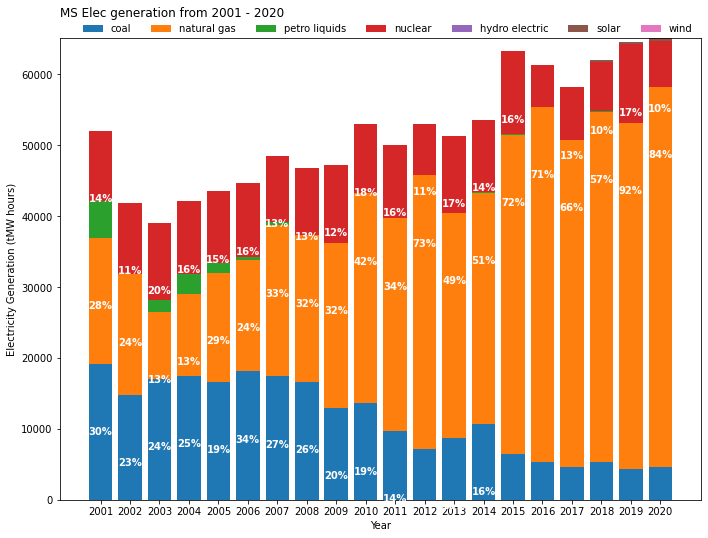

MS is done!


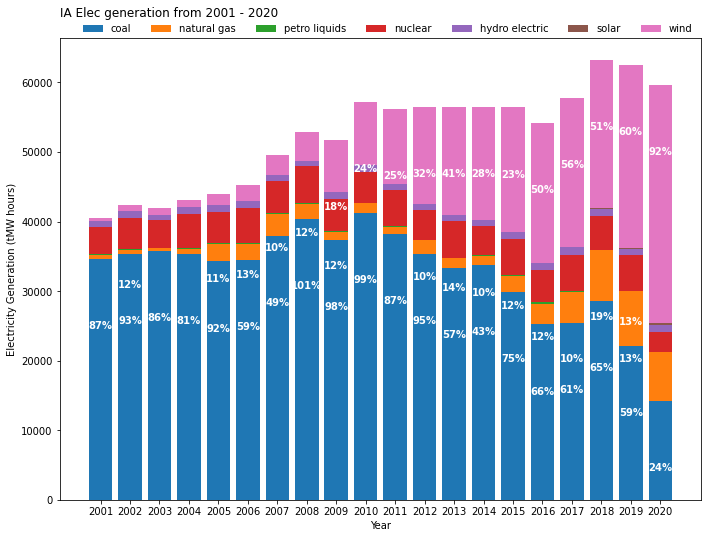

IA is done!


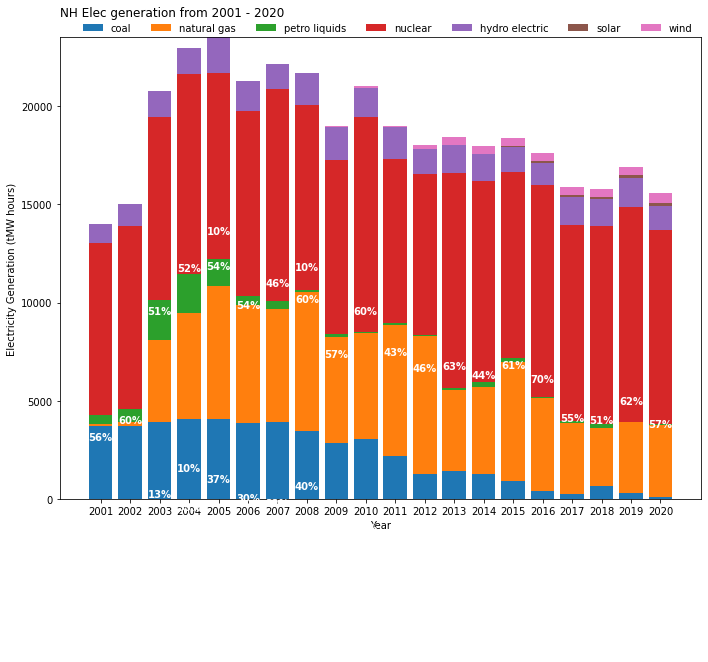

NH is done!


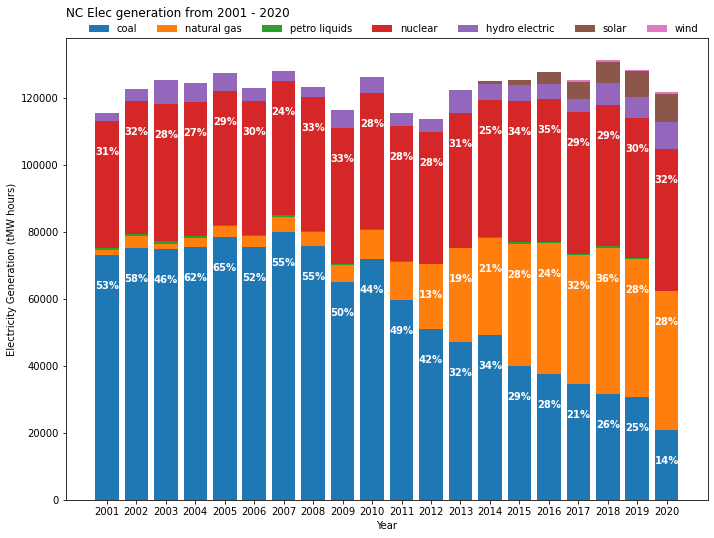

NC is done!


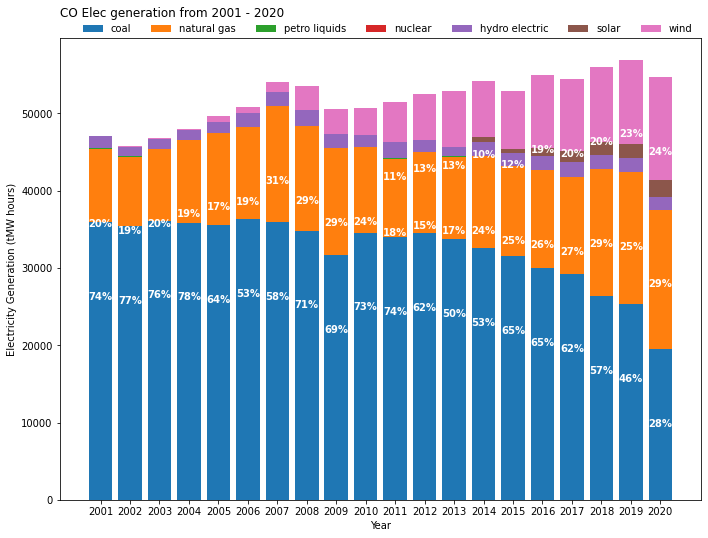

CO is done!


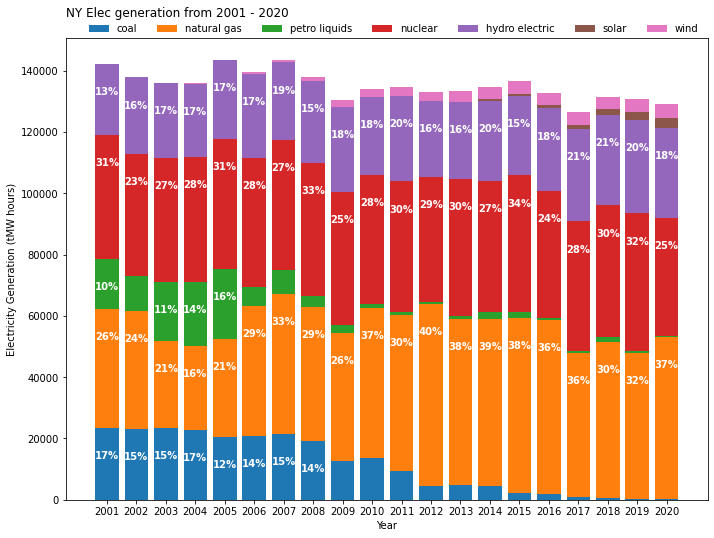

NY is done!


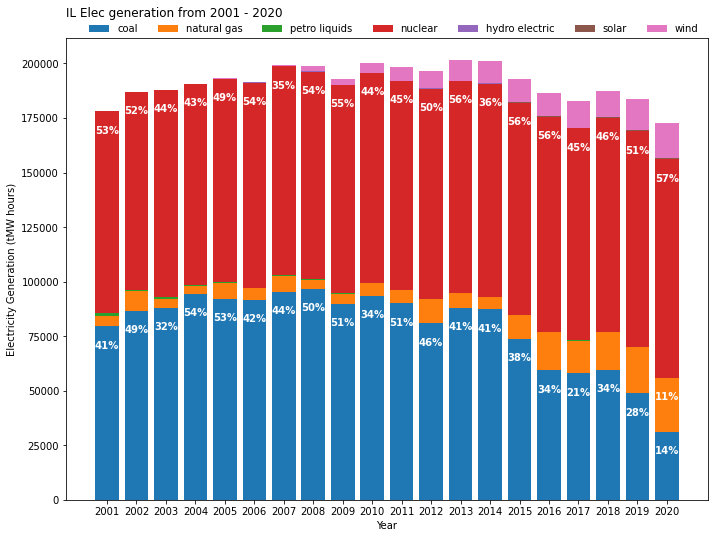

IL is done!


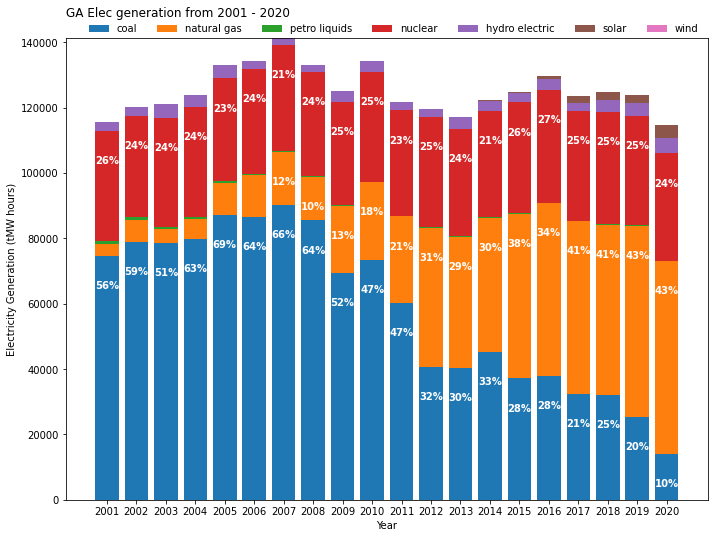

GA is done!


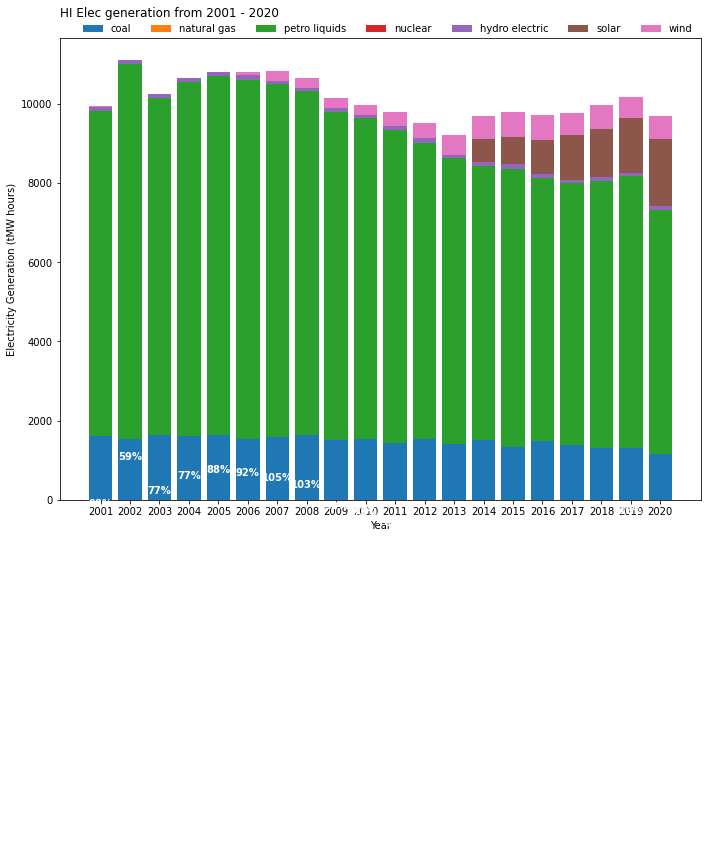

HI is done!


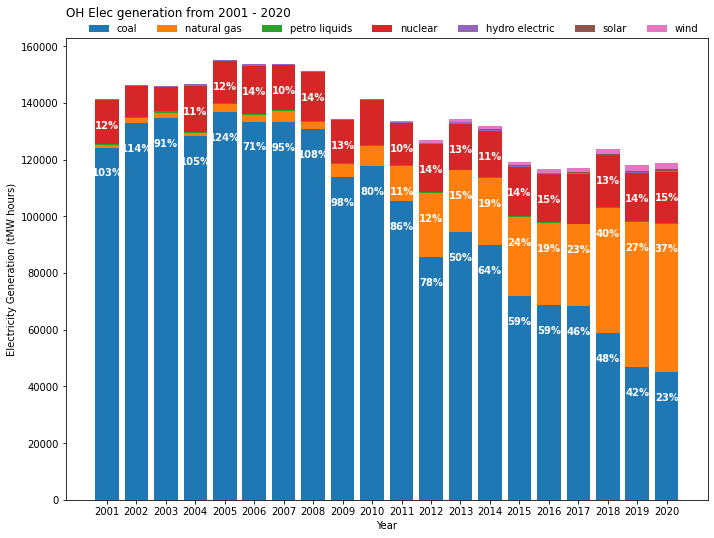

OH is done!


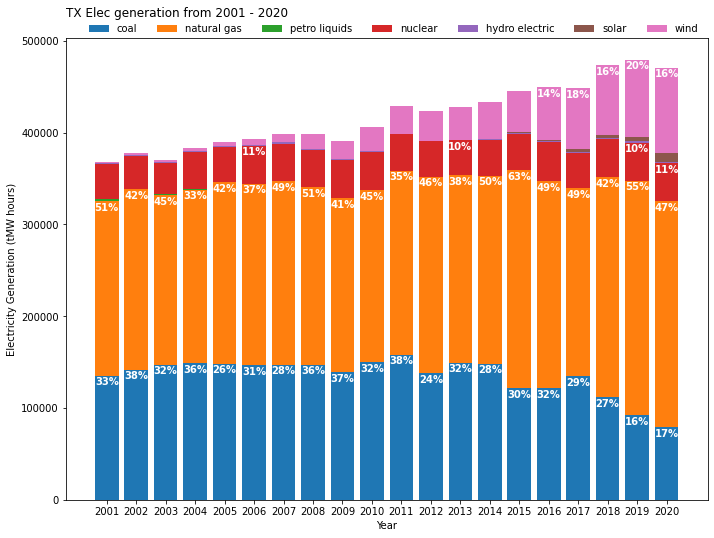

TX is done!


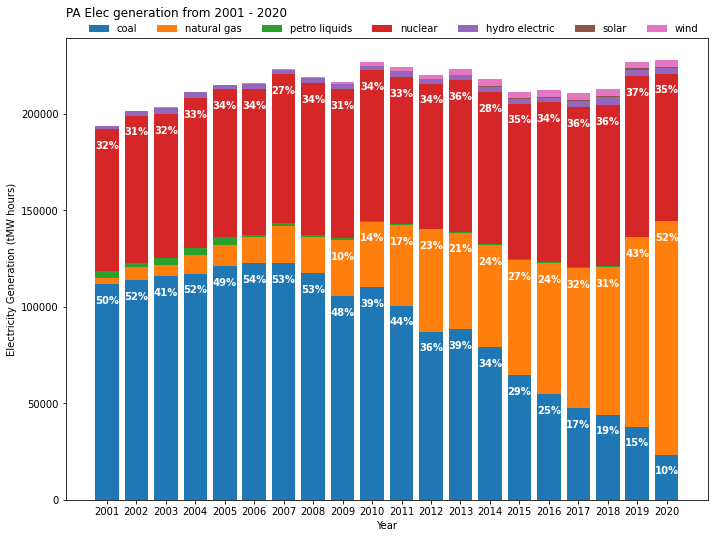

PA is done!


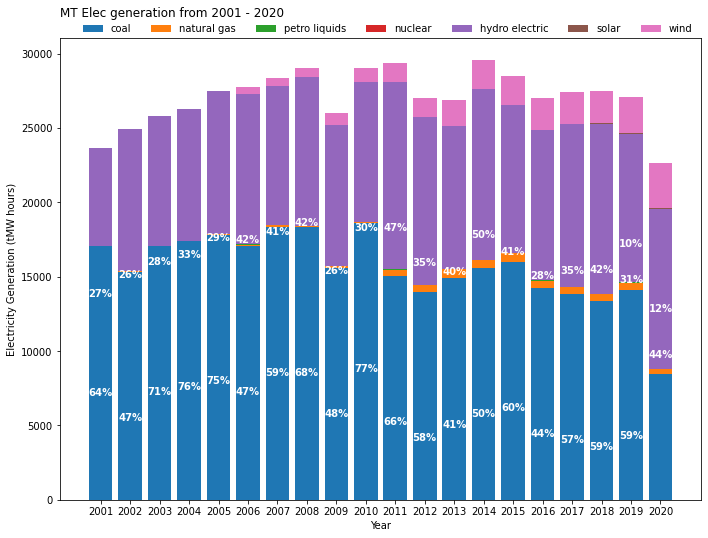

MT is done!


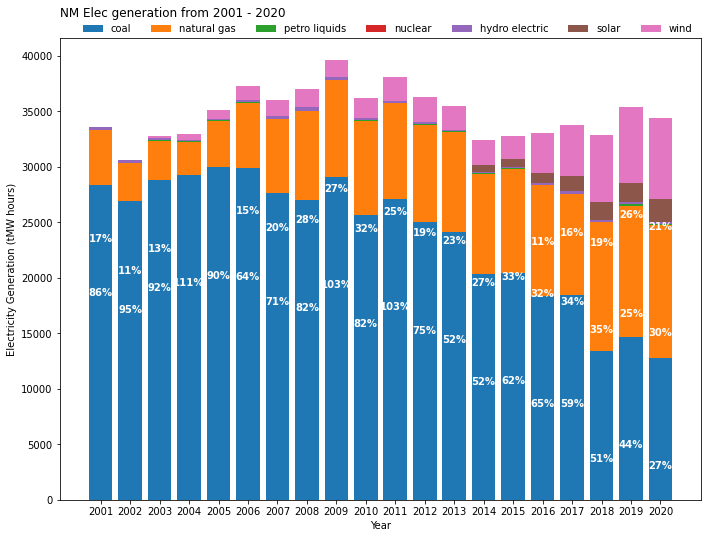

NM is done!


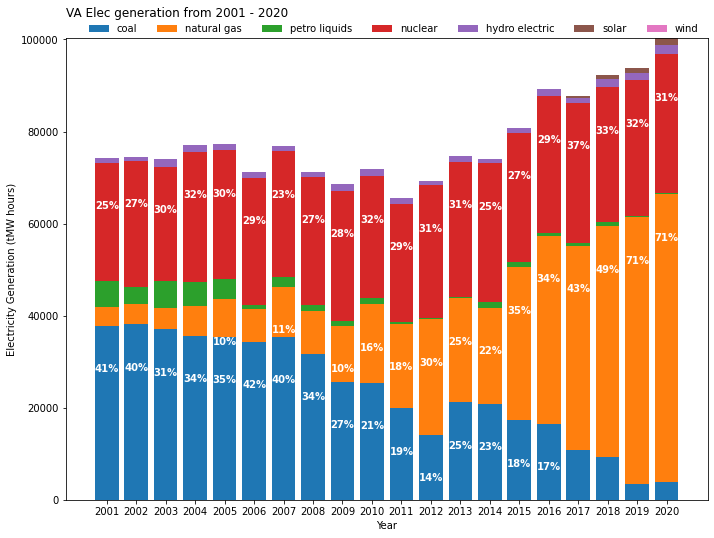

VA is done!


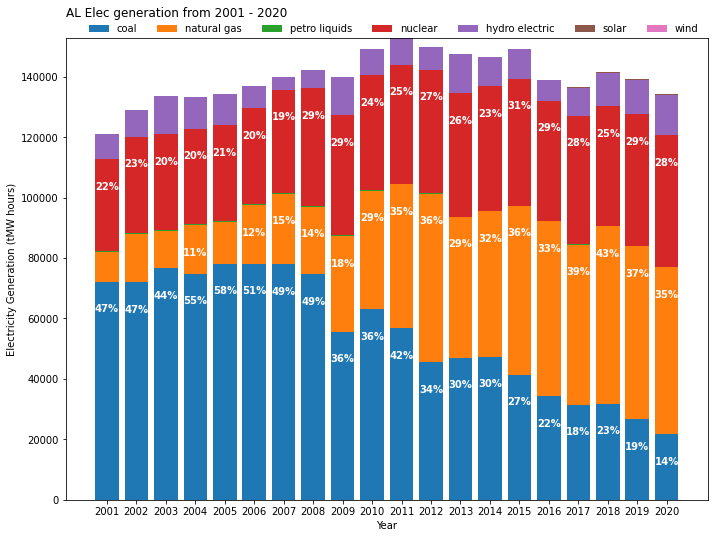

AL is done!


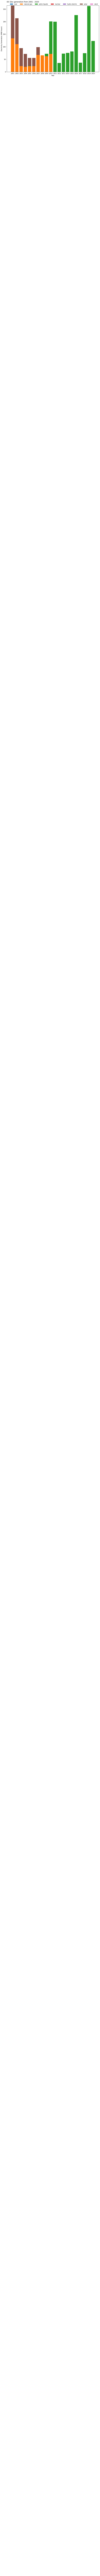

DC is done!


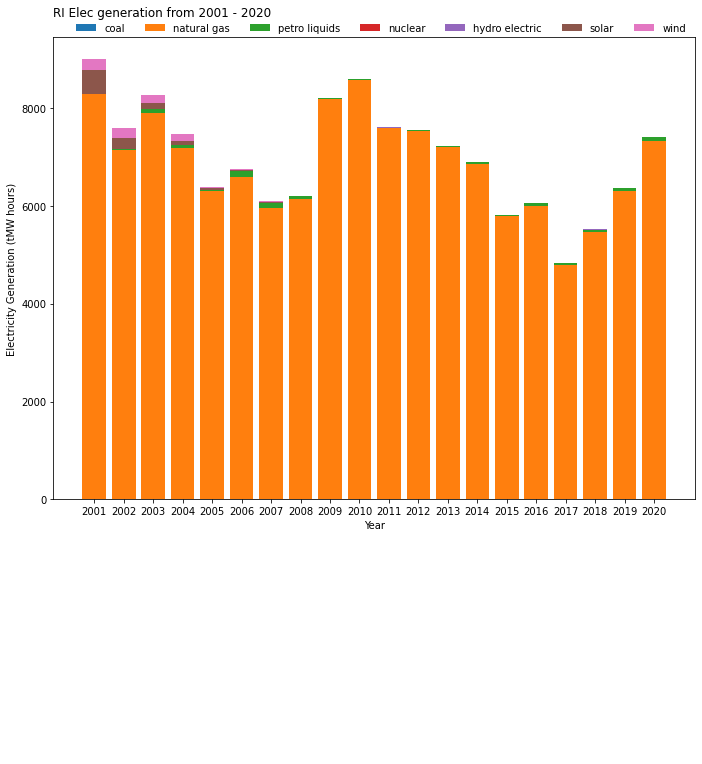

RI is done!


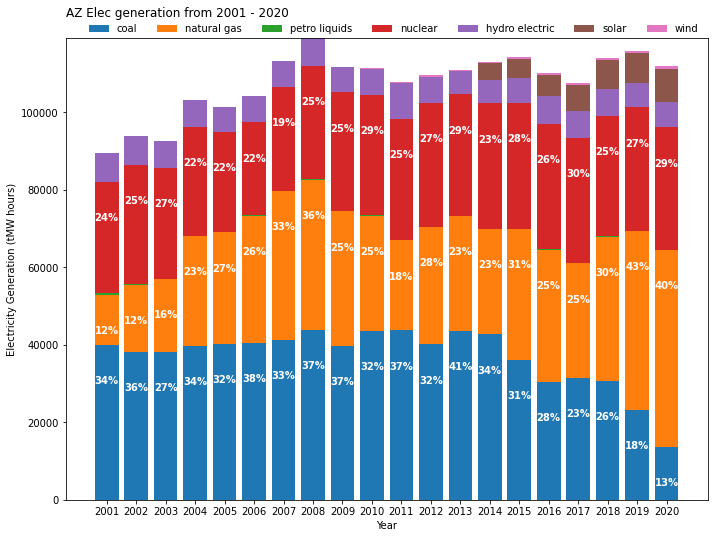

AZ is done!


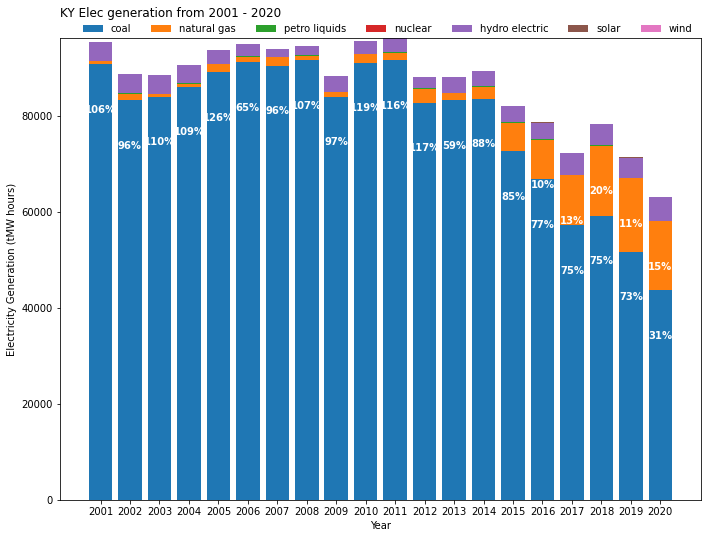

KY is done!


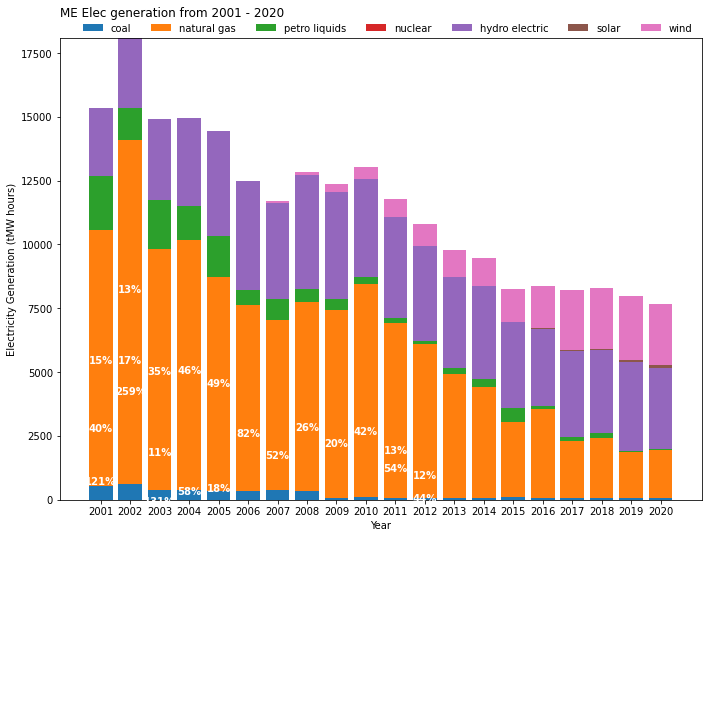

ME is done!


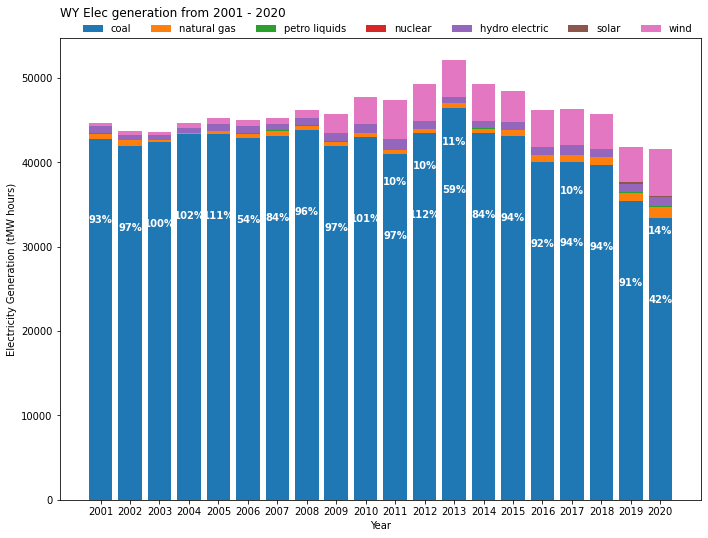

WY is done!


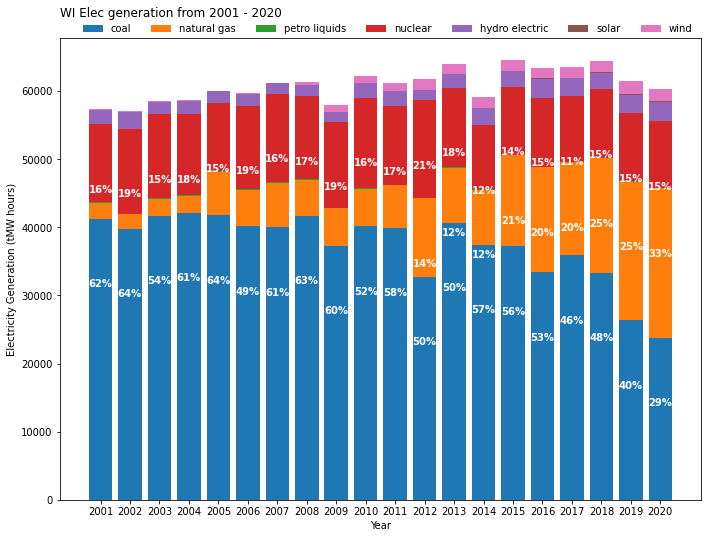

WI is done!


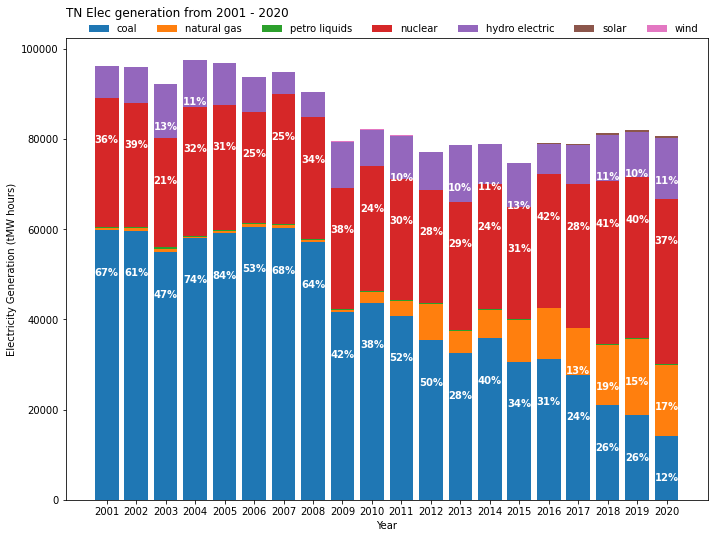

TN is done!


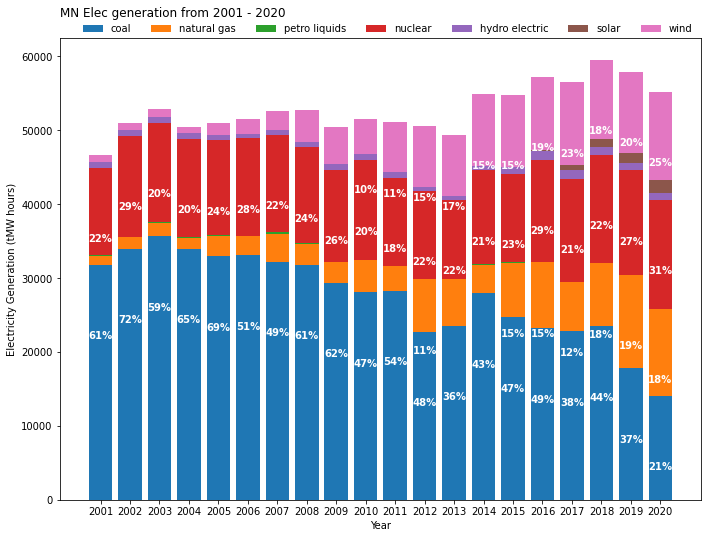

MN is done!


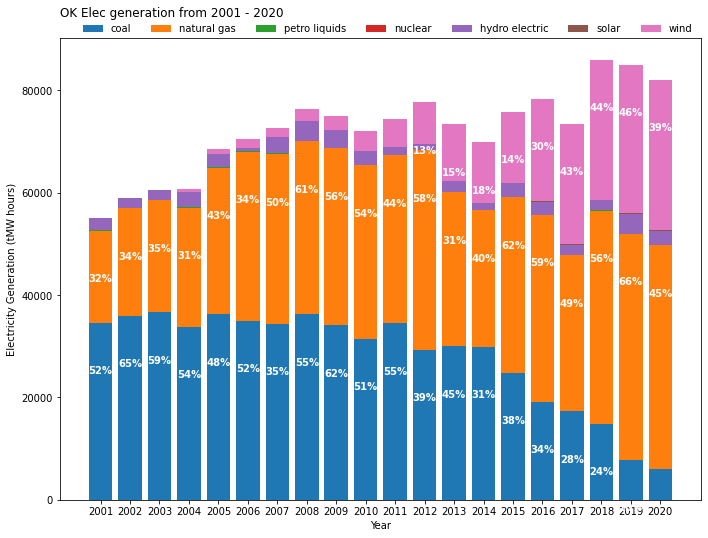

OK is done!


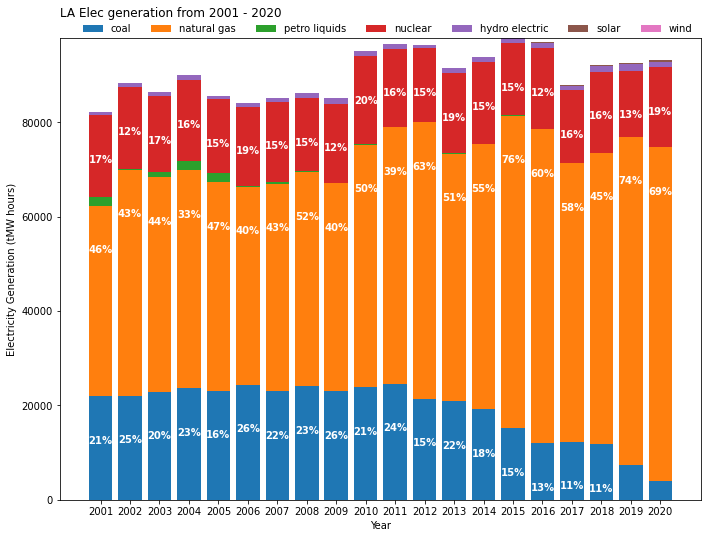

LA is done!


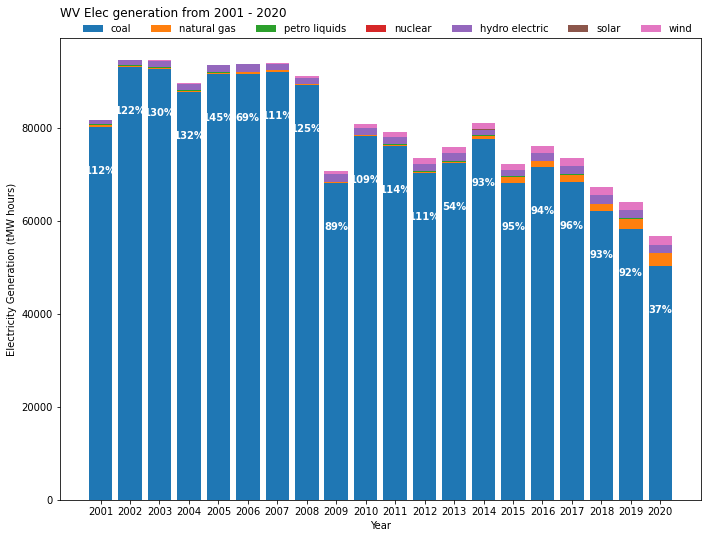

WV is done!


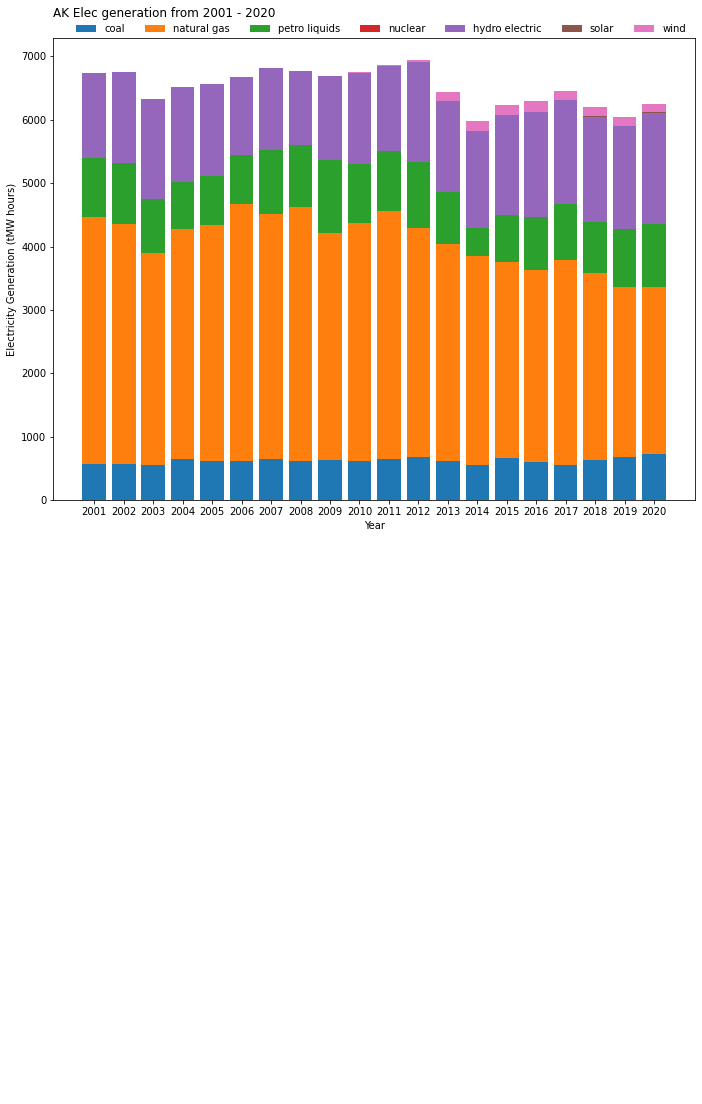

AK is done!


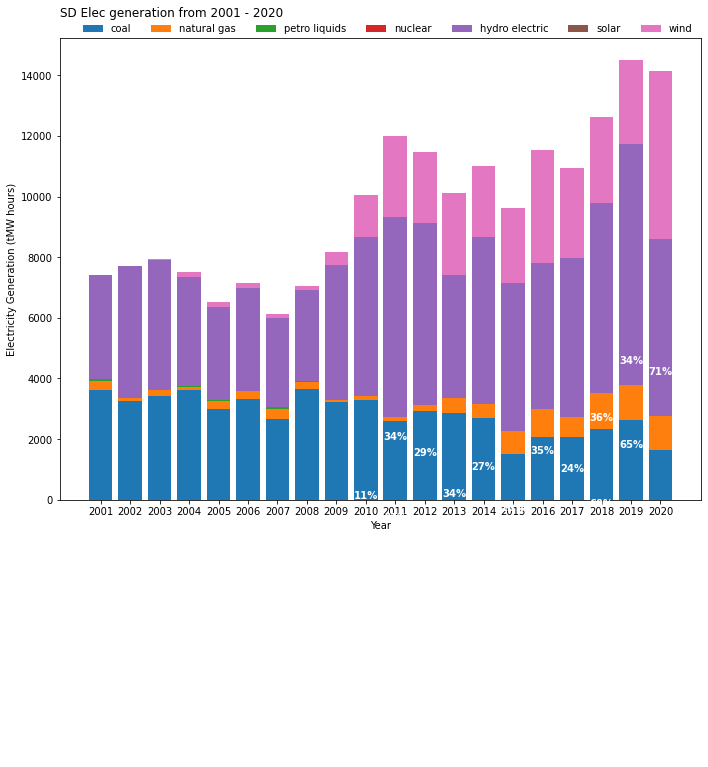

SD is done!


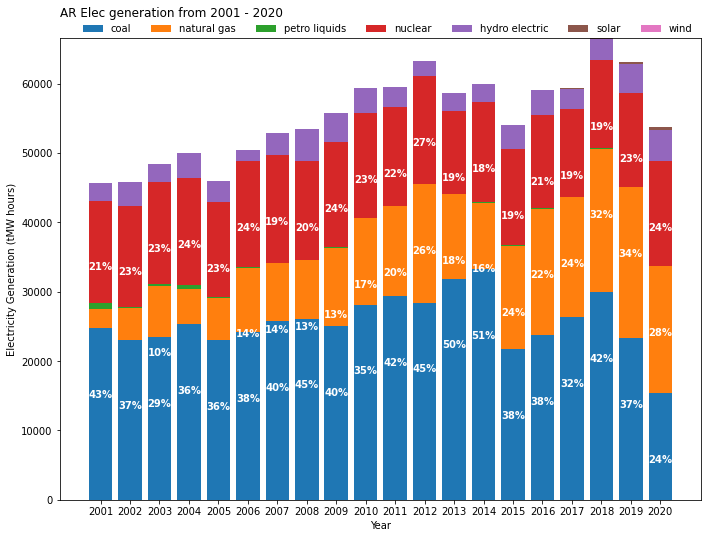

AR is done!


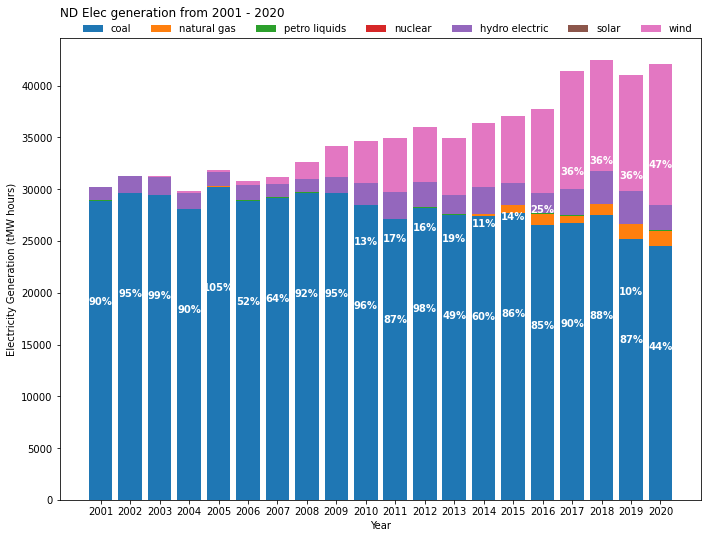

ND is done!


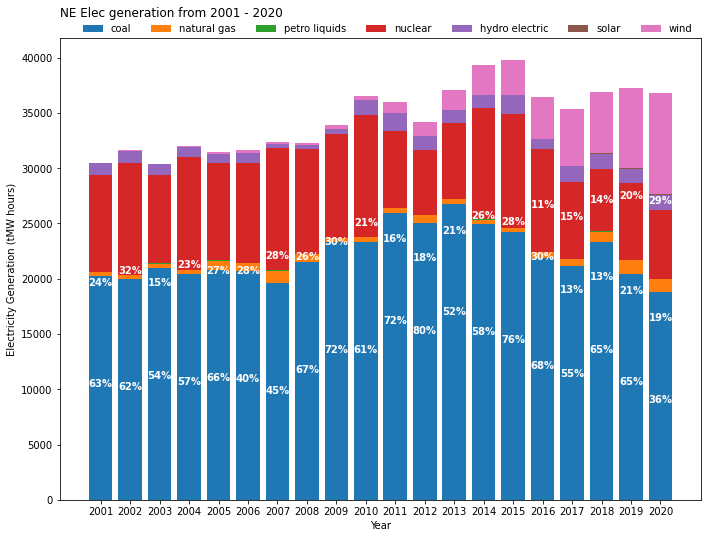

NE is done!


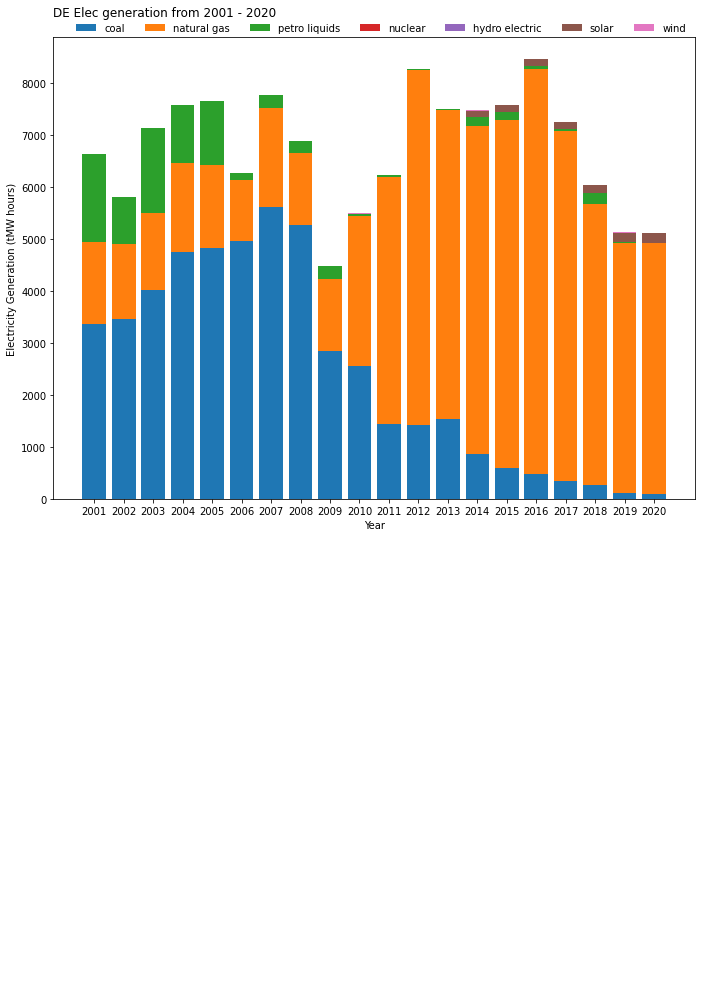

DE is done!


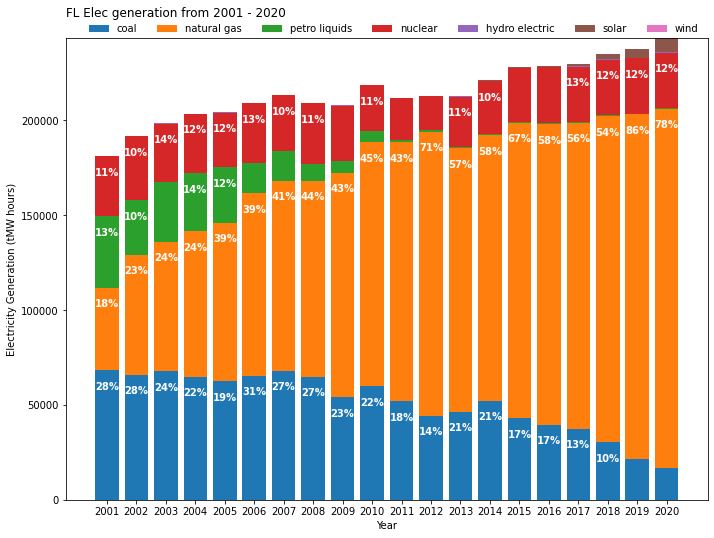

FL is done!


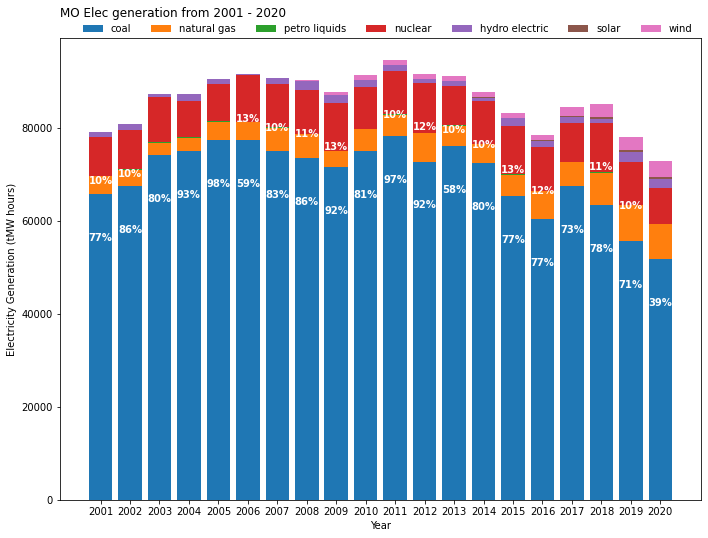

MO is done!


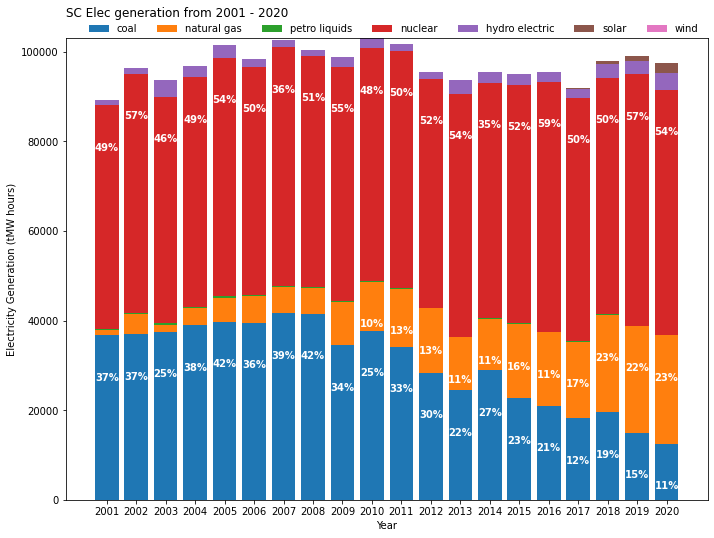

SC is done!


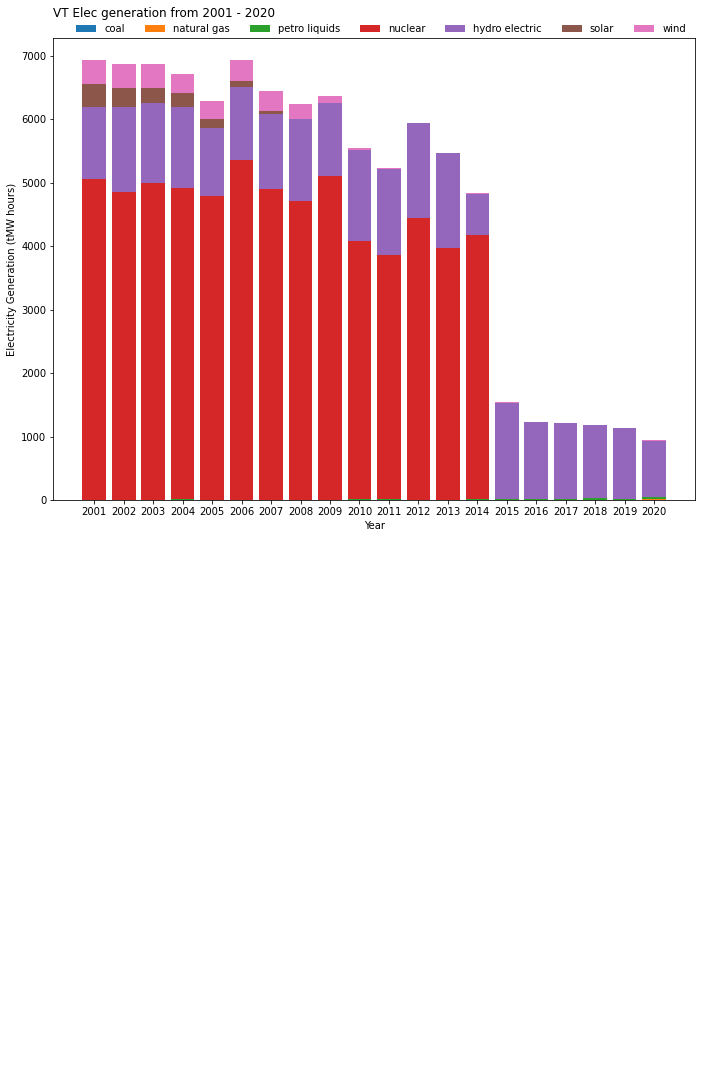

VT is done!


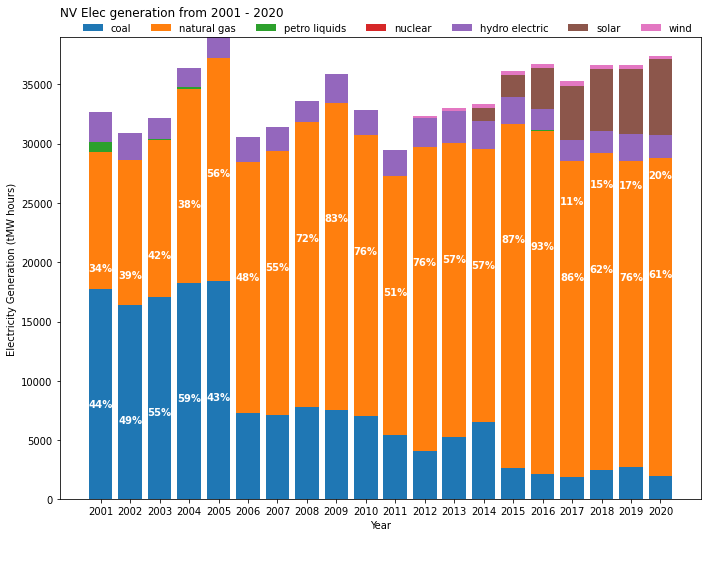

NV is done!


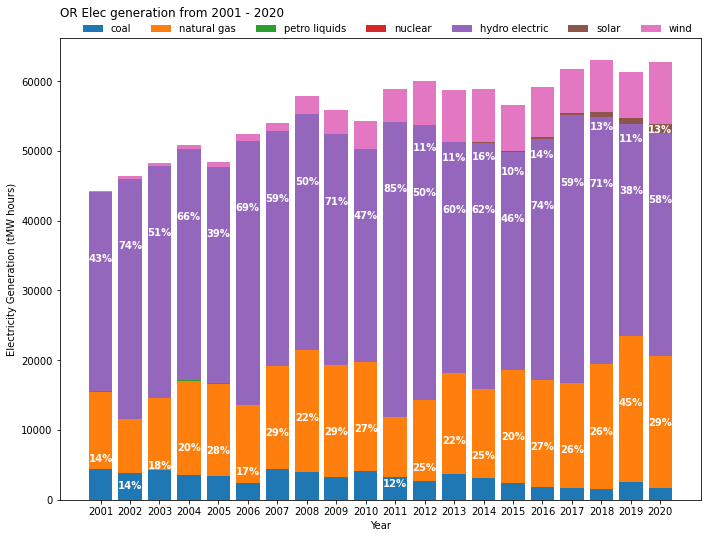

OR is done!


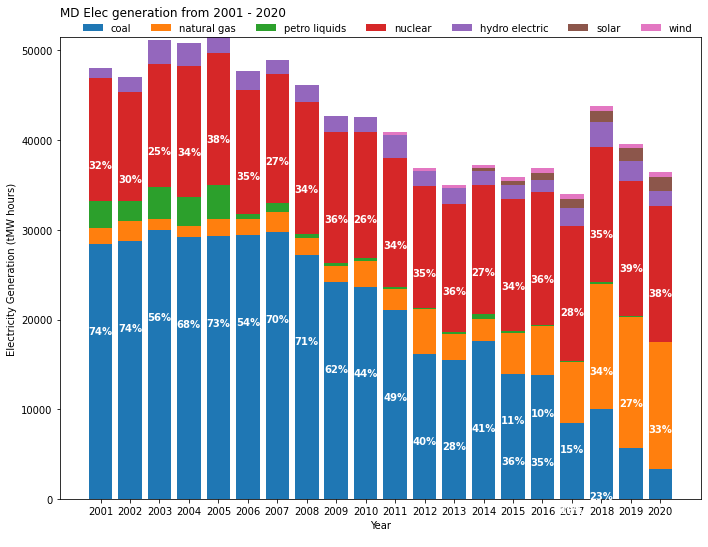

MD is done!


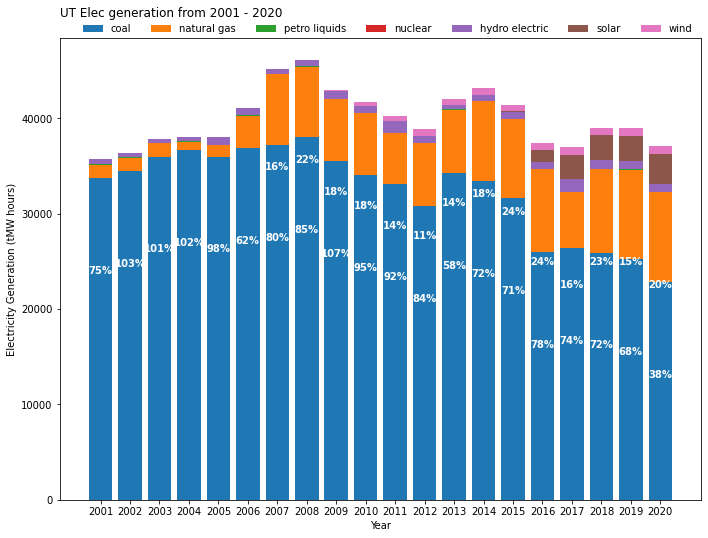

UT is done!


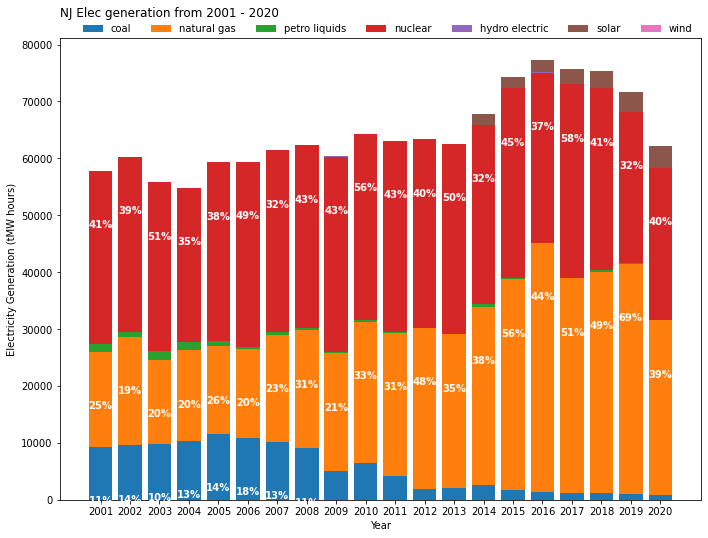

NJ is done!


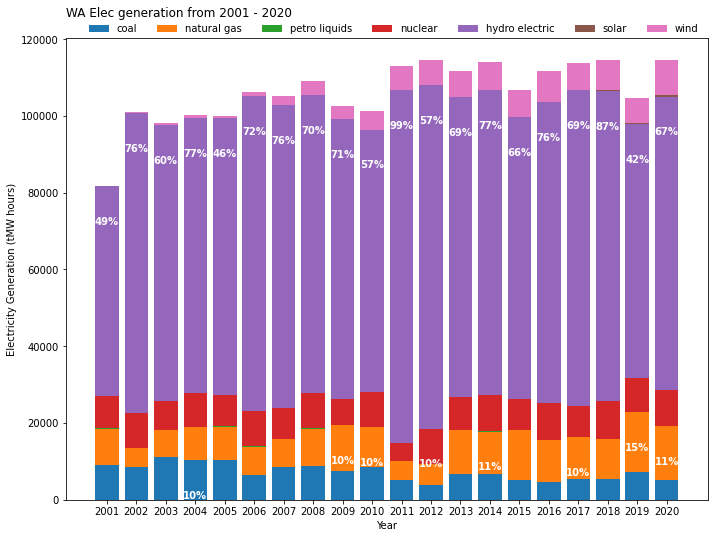

WA is done!


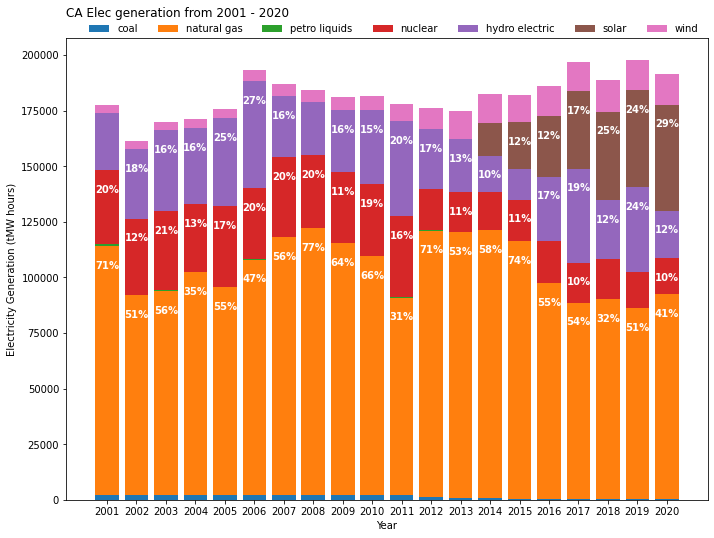

CA is done!


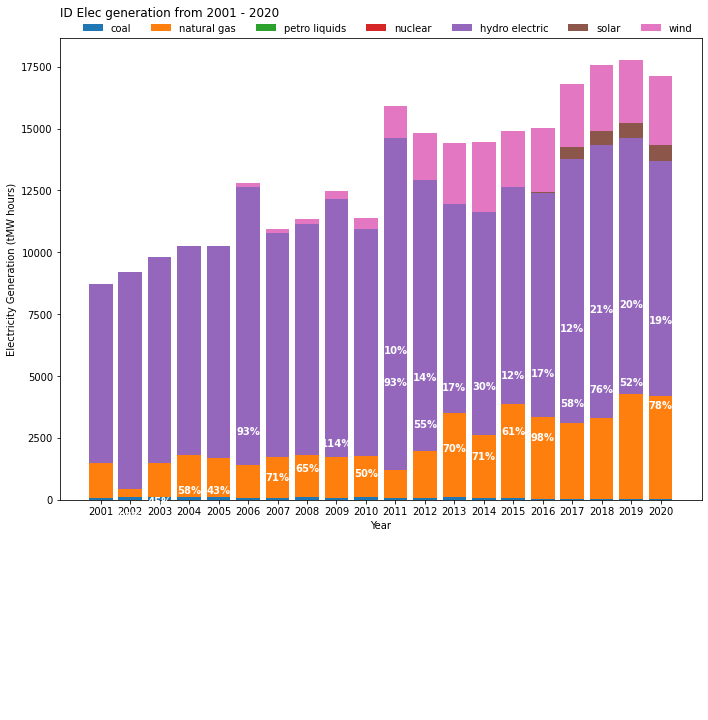

ID is done!


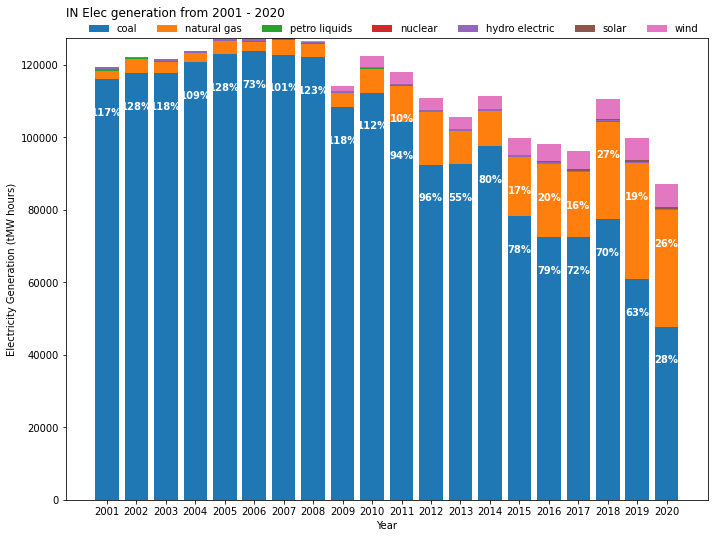

IN is done!


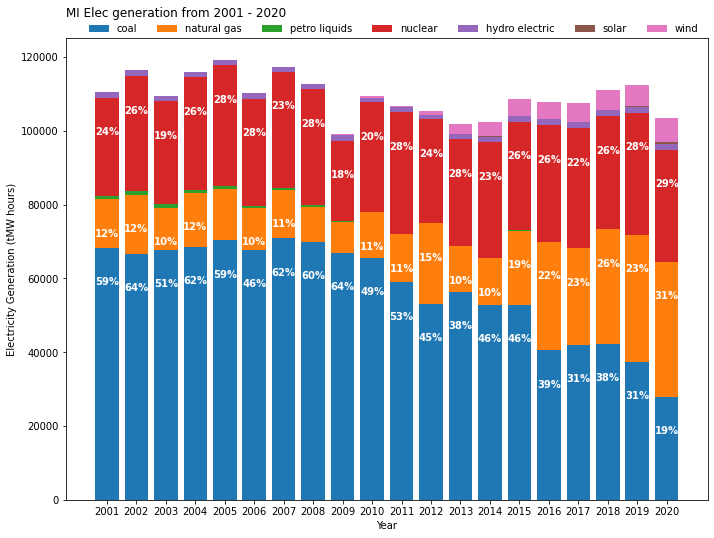

MI is done!


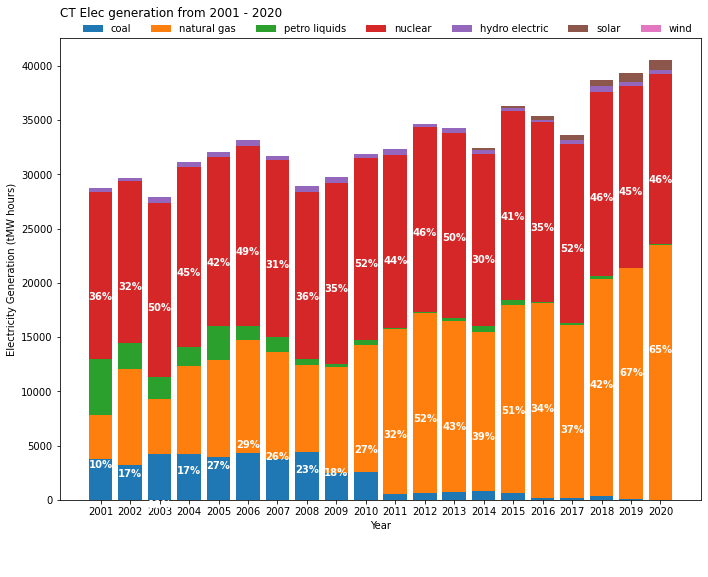

CT is done!


In [54]:
# First, let's grab all of the unique values in the us_emissions data and set it to a list
generation_states = list(set(electric_gen['state']))

# prep the us_emissions data so it has the groupings that we need
electric_gen = group_df_by_generation(electric_gen)
cols_totals = ['coal', 'natural_gas', 'petro_liquids', 'nuclear', 'hydro_electric', 'all_solar', 'wind']

# loop through all of the states and save them individually in their folder
for state in generation_states:
    show_area_plot_over_years_generation(
            electric_gen.loc[(electric_gen['state']==state)], 
            cols_totals)
    
    print('{} is done!'.format(state))